![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

This project analyzes sales data from Kings County, Washington. The goal is to build a model that reasonably accurately predicts change in home prices and helps inform actionable business recommendations for our stakeholder. This notebook contains sections for (1) exploratory data analysis / understanding (2) data cleaning and (3) modeling. We will use multiple linear regression as our main modelling tool.

## Business Problem

- Our stakeholder is a small-time property developer / real estate firm that is looking to expand its presence in Kings County
- Historically, they've primarily operated out of state, and are unfamiliar with the local dynamics of this real estate market.
- They've asked us to help determine some of the key drivers of changes in home price in this key market.
- Given this ask, we will look for meaningful predictors that will help the developer focus their efforts on homes that will sell for more.
- This is important as it allows the developer to avoid wasting time or money on buying / developing properties with features that are unlikely to change the home price materially.

## Data Understanding

- The data represents ~22K home sales in Kings County, Washington from September 2014 through January 2015
- The data includes the sale price of the home and a number of descriptors, including many variables about size (number of rooms, square footage, lot size), location (zip code, lat / lon), and other attributes (waterfront, basement, etc).
- The key target variable will be sale price of the home.
- For our model, we will testing which features of the house (or combinations of features) has (1) the most predictive value for home price and (2) is a meangingful contributor to changes in home price (coefficient)
- In addition to home features, we will also incorporate a geographic analysis by neighborhood

In [261]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

# Import functions to run and evaluate regression models
from util import run_model, evaluate_model, high_corr

# Set style
plt.style.use('seaborn')

In [2]:
# Import data

df_sales = pd.read_csv('kc_house_data.csv')

In [3]:
# Run info to check for general data types and nulls

df_sales.info()

# Summary: all are numbers except Date and Basement_sqft. The latter should probably be converted to a number.
# Some of the numbers are likely categorical and need to be treated as such.
# 22K entries total. Most columns do not contain nulls (will need to clean up waterfront and yr_renovated)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Dependent variable will be 'price'

### Numeric data exploration

In [5]:
df_num = df_sales.select_dtypes(include=['float64', 'int64'])

In [6]:
y = df_num['price']
X = df_num.drop(columns=['price','id', 'lat', 'long'], axis=1)

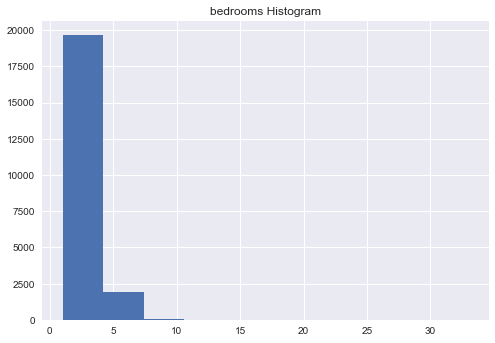

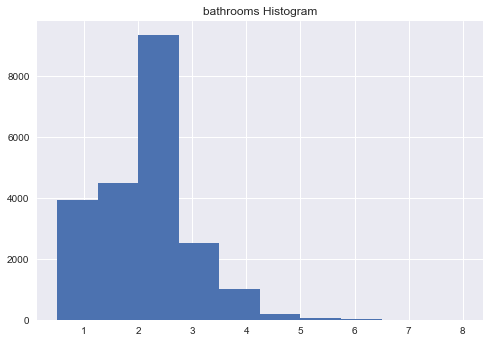

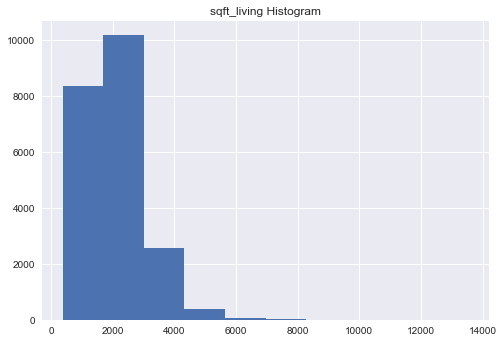

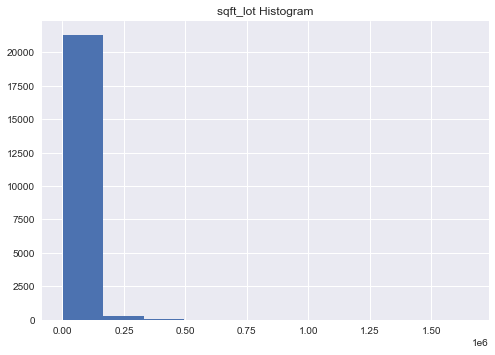

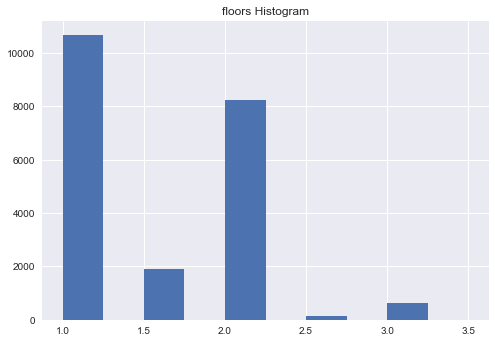

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


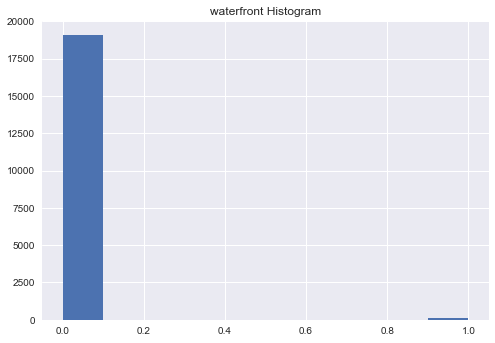

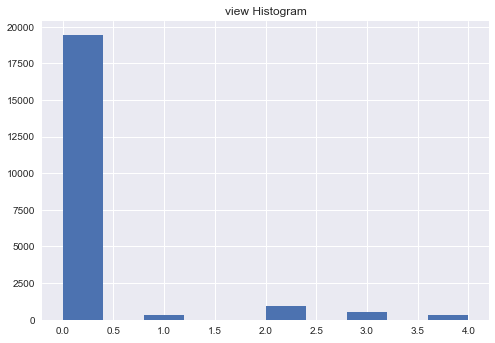

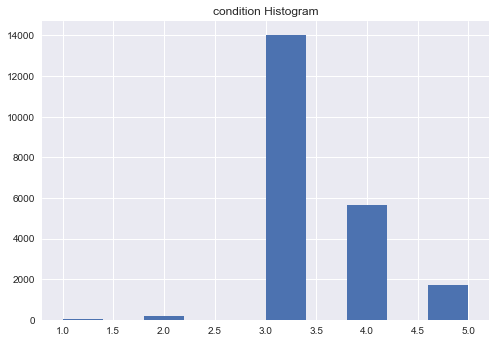

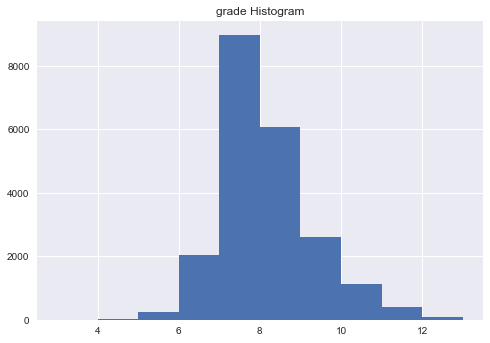

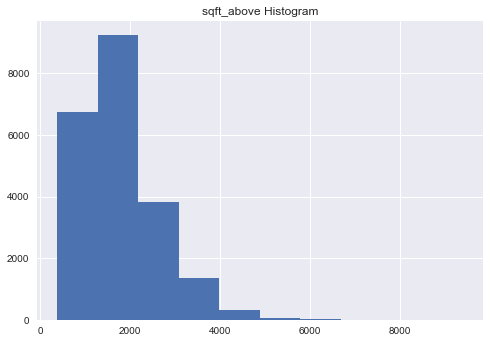

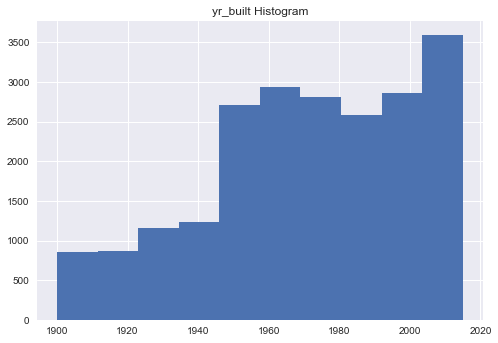

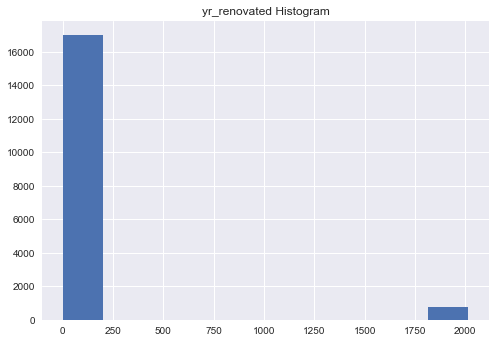

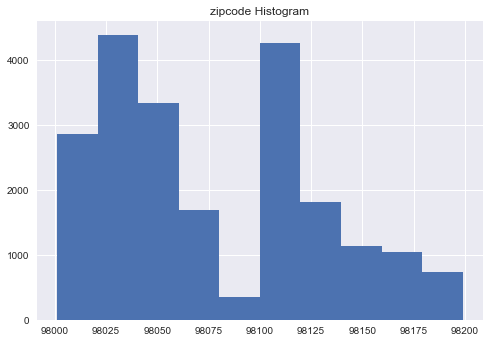

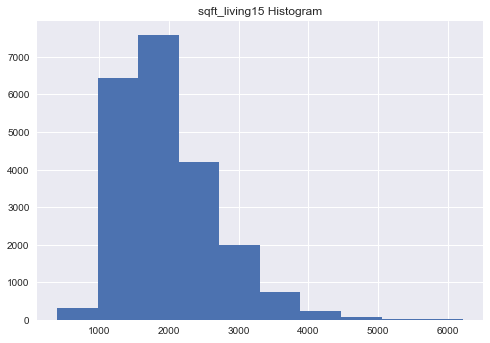

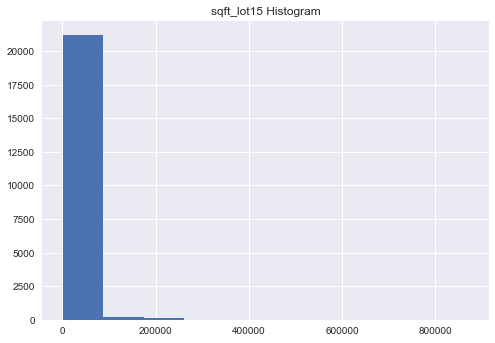

In [7]:
# Check for normality

for col in X.columns:
    plt.hist(X[col])
    plt.title(f"{col} Histogram")
    plt.show();
    
# Conclusions: 
# * Transform bedrooms and bathrooms into categorical variables
# * Log transform sqft_living to normalize it
# * Check for collinearity among the "size" metrics
# * Transform floors to a categorical variable
# * Make condition a categorical by 4+ as good condition
# * Keep grade as a continuous variable


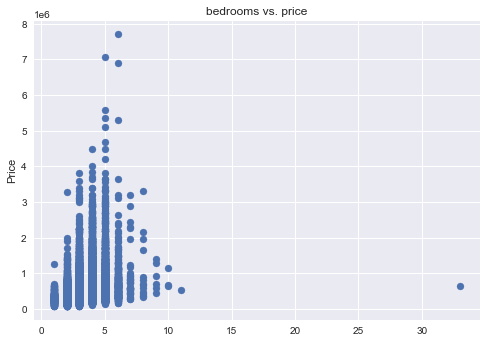

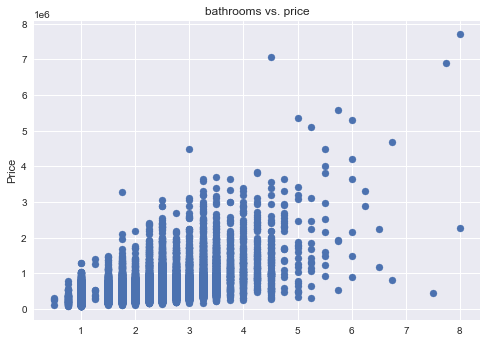

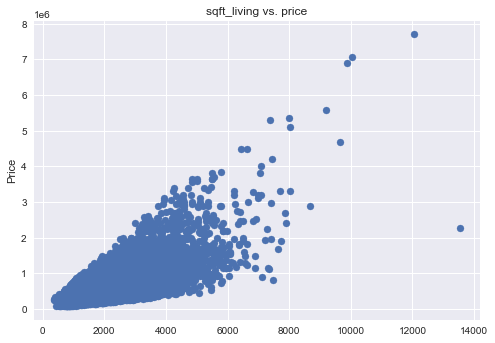

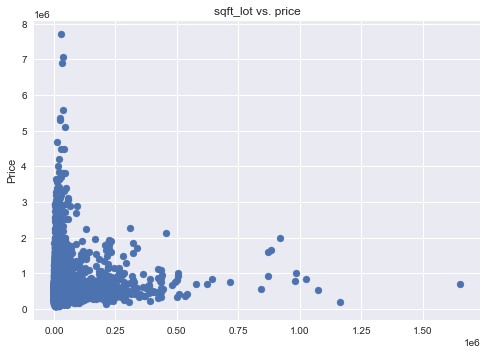

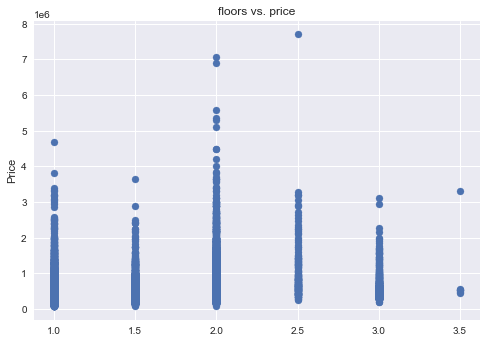

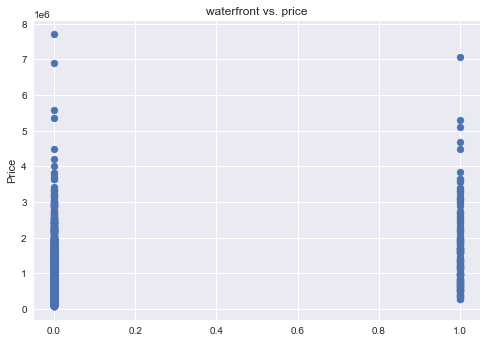

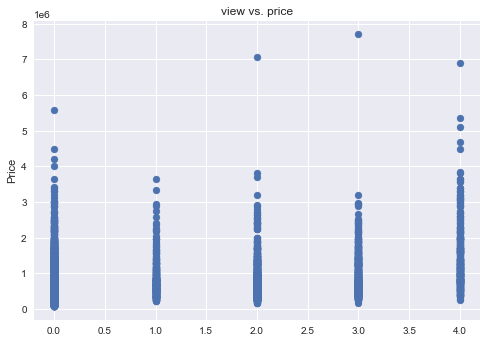

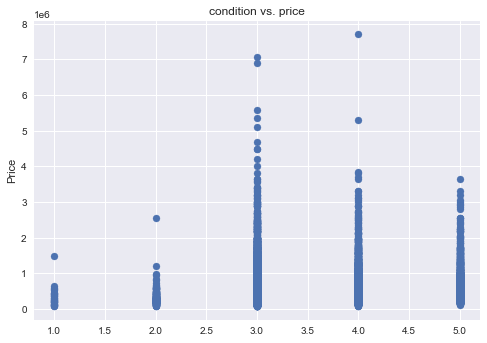

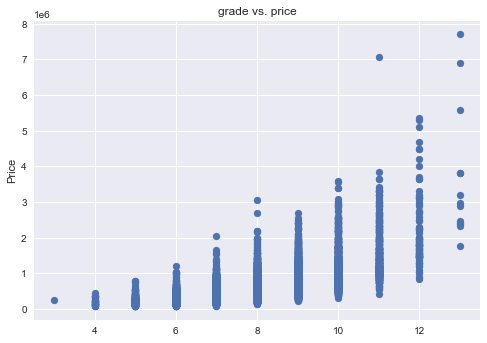

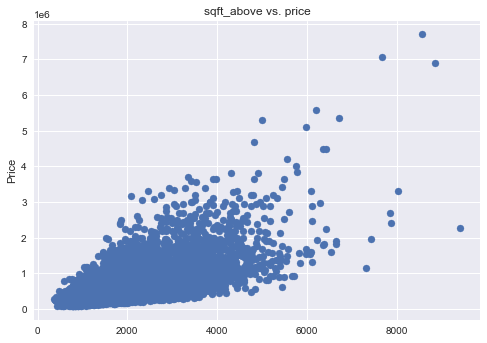

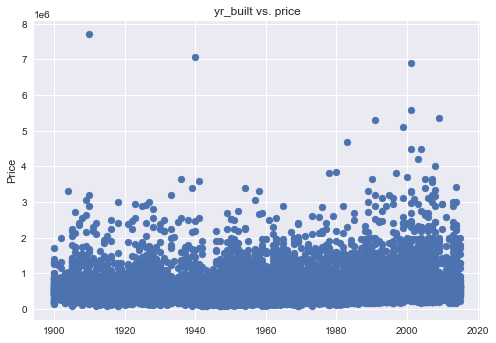

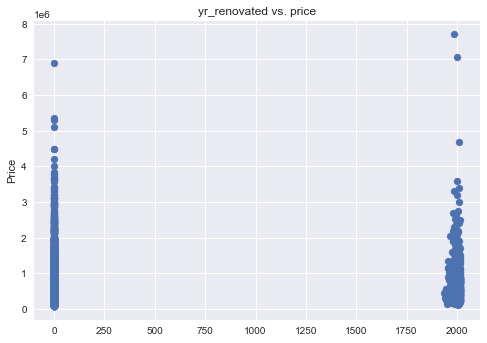

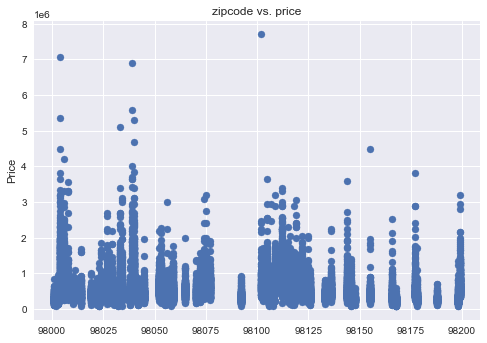

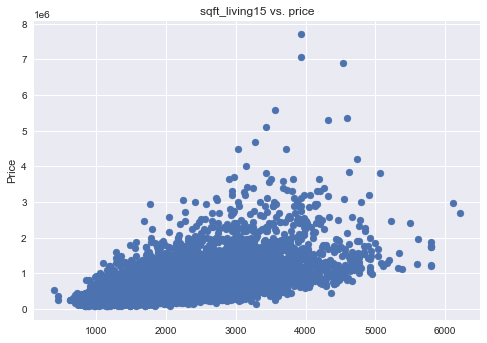

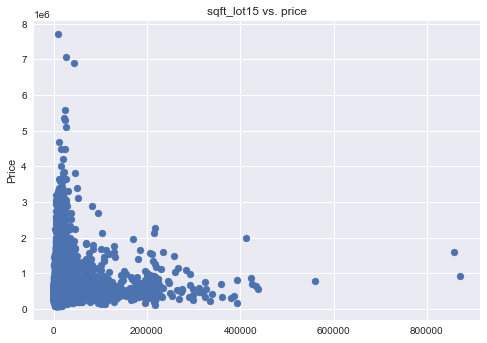

In [8]:
# Check for linear relationship between numbers and sales

for col in X.columns:
    plt.scatter(X[col], y)
    plt.title(f"{col} vs. price")
    plt.ylabel("Price")
    plt.show();

### Futher exploration of the 'numerical' variables that we may want to transform to categorical

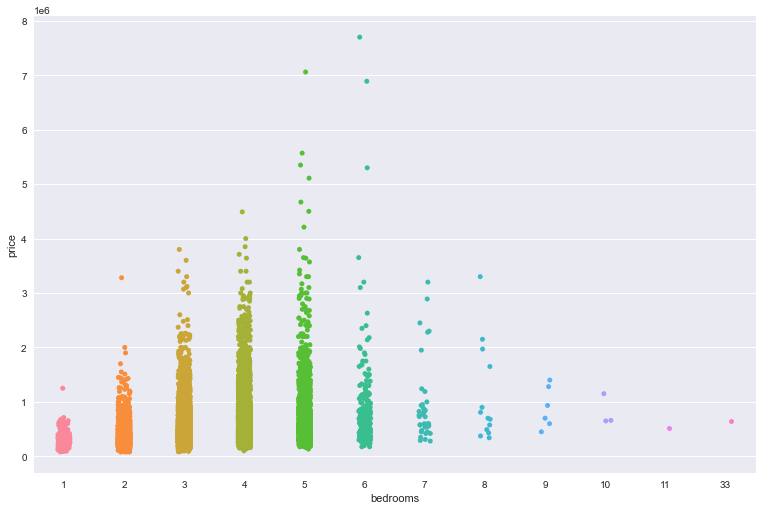

In [9]:
# Interesting doesn't appear to be much of a trend here from this graph. Notice obvious outliers

sns.catplot(x='bedrooms', y='price', data=df_sales, height=7, aspect=1.5);

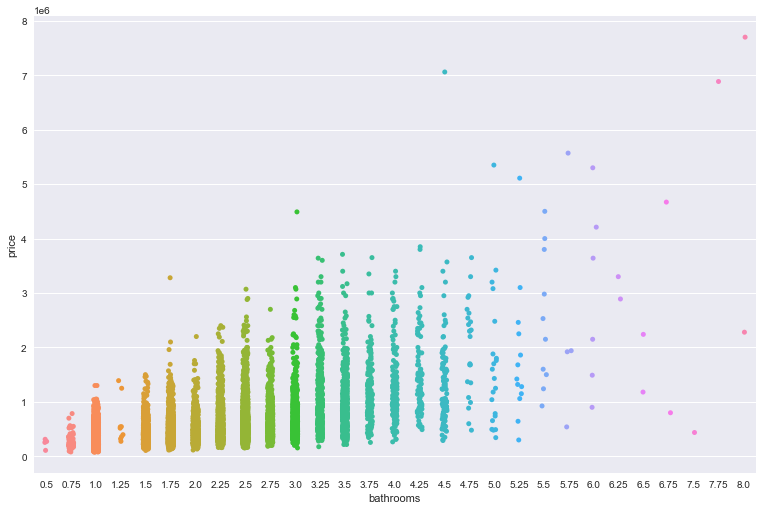

In [10]:
# Bathrooms seems to have a somewhat positive, linear relationship with price

sns.catplot(x='bathrooms', y='price', data=df_sales, height=7, aspect=1.5);

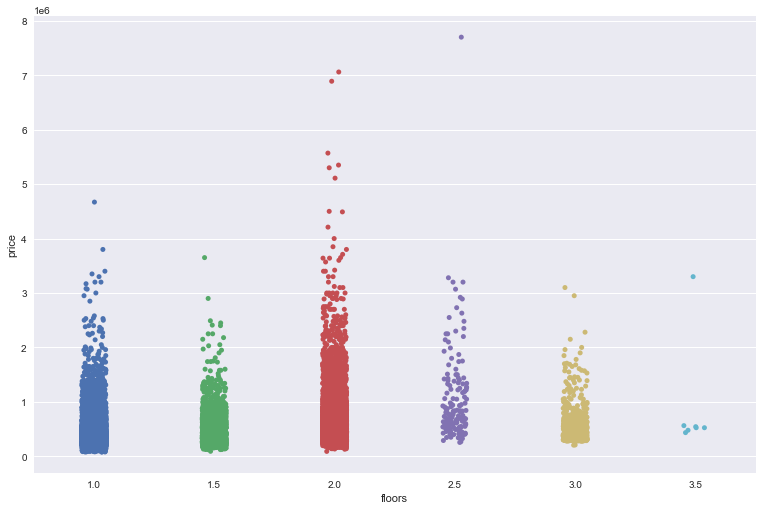

In [11]:
# Homes with two flors seem to have more homes with a higher price

sns.catplot(x='floors', y='price', data=df_sales, height=7, aspect=1.5);

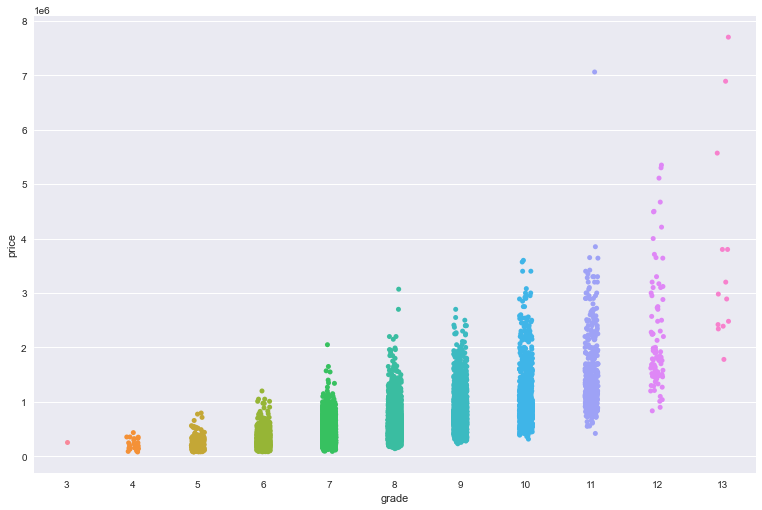

In [12]:
# Clear positive relationship between grade and price

sns.catplot(x='grade', y='price', data=df_sales, height=7, aspect=1.5);

In [13]:
df_sales['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

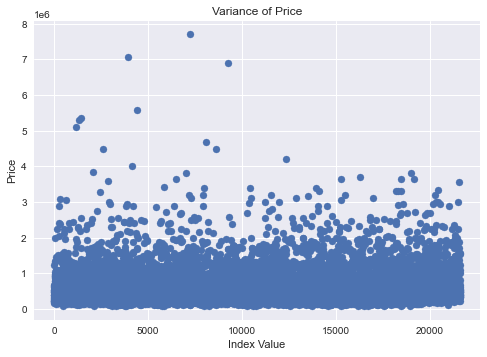

In [14]:
# also plot sales against itself
plt.scatter(y.index, y)
# plt.hlines(y.mean(), 0, 3000000)
plt.xlabel('Index Value')
plt.ylabel('Price')
plt.title('Variance of Price')
plt.show()

# There are some outliers in price. This can be narrowed down by limiting the scope of our business problem.

### Non-numeric data exploration

Covering date and sqft_basement

In [16]:
# This dataset contains home sales from September 2014 through January 2015.
# Will not likely use date in any meaningful way

latest_date = df_sales['date'].min()
earliest_date = df_sales['date'].max()

sorted_date = df_sales['date'].sort_values(ascending=False)

print(earliest_date, latest_date)

9/9/2014 1/10/2015


In [17]:
# There are 304 unique values here. 12K of them are 0. 
# Two steps:
# Converted to numerical
# Used to create a new binary categorical variable "has_basement"

print(len(df_sales['sqft_basement'].unique()))
(df_sales['sqft_basement'] == '0.0').sum()

304


12826

### Categorical variables

Exploring which fields are categorical, and how to deal with them

In [18]:
# Based column description, there are a few existing categorical variables and a few fields that we may want
# to transform into categorical variables

# Existing categorical variables
existing_cat = ['waterfront', 'view', 'zipcode']

# Fields we may want to transform into categorical variables
potential_cat = ['yr_built', 'yr_renovated', 'sqft_basement', 'floors']

# yr_built: could divide in binary variable called "recently built" to show developer new houses sell well
# sqft_basement: transform into variable showing whether there's a basement or not
# yr_renovated: transform into whether the house has been renovated or not
# floors: transform into binary variable for having multiple stories or not

### Outliers

Identifying outliers among the data

In [19]:
df_sales.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,21597,21597,21597,21597,21597,21597,19221,21534,21597,21597,21597,21597,17755,21597,21597,21597,21597,21597
mean,4580474288,540297,3,2,2080,15099,1,0,0,3,8,1789,1971,84,98078,48,-122,1987,12758
std,2876735716,367368,1,1,918,41413,1,0,1,1,1,828,29,400,54,0,0,685,27274
min,1000102,78000,1,0,370,520,1,0,0,1,3,370,1900,0,98001,47,-123,399,651
25%,2123049175,322000,3,2,1430,5040,1,0,0,3,7,1190,1951,0,98033,47,-122,1490,5100
50%,3904930410,450000,3,2,1910,7618,2,0,0,3,7,1560,1975,0,98065,48,-122,1840,7620
75%,7308900490,645000,4,2,2550,10685,2,0,0,4,8,2210,1997,0,98118,48,-122,2360,10083
max,9900000190,7700000,33,8,13540,1651359,4,1,4,5,13,9410,2015,2015,98199,48,-121,6210,871200


In [20]:
# There appear to be outliers in 'bedrooms', 'grade', and 'sqft_lot' based on max values

# Bedroom outlier check
bedroom_outlier = df_sales[df_sales['bedrooms'] == 33]

bedroom_outlier

# Conclusion: seems to be a typo. Filter for everything with fewer than 8 bedrooms as our developer is 
# unlikely to want to build these properties

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [21]:
df_sales['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [22]:
# Grade outlier check

df_sales['grade'].value_counts()

# Conclusion: not actually an outlier. Grades go up to 13 and indicate the quality of materials used.

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [23]:
sns.set_theme(style="dark")

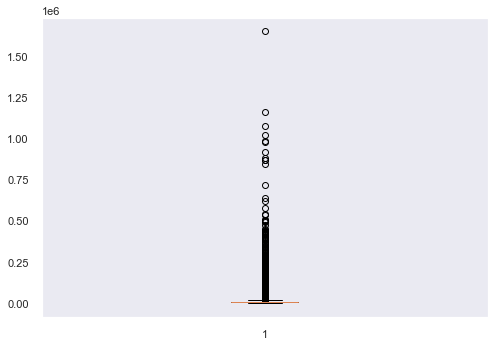

In [131]:
# Sqft_lot check

fig, ax = plt.subplots()

ax.boxplot(df_sales['sqft_lot']);


# Conclusion: while possible a valid entry, 1.6mm square feet converts to 38 acres.
# The developer is unlikely to consider building on property more than a few acres large.
# Can probably apply a filter of 200K square feet for lot size (~4.5 acres). This covers 99% of the dataset

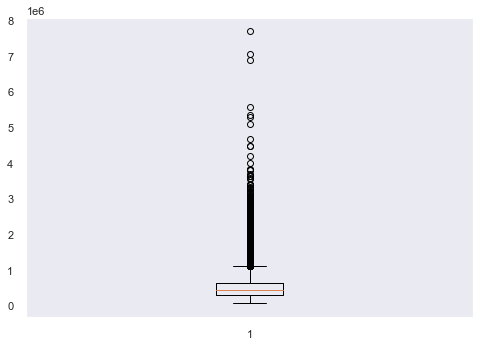

In [25]:
# Price check. Can deal with outliers here by narrowing the scope of housing features under consideration.
# some more extreme values

plt.boxplot(df_sales['price']);

In [26]:
len(df_sales[df_sales['price'] <= 2000000]) / len(df_sales)

0.9908320600083345

In [27]:
num = 200000

len(df_sales[df_sales['sqft_lot'] < num]) / len(df_sales)

0.9880538963744965

### Null values

Determining what to do with Nulls

In [28]:
df_sales.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [29]:
# View
# Conclusion: Given the overwhelming tendency towards 0, replace the null values with 0

df_sales['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [30]:
df_sales[df_sales['waterfront'].isna()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
10,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,NaN,0.0,...,8,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
23,8091400200,5/16/2014,252700.0,2,1.50,1070,9643,1.0,NaN,0.0,...,7,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
40,5547700270,7/15/2014,625000.0,4,2.50,2570,5520,2.0,NaN,0.0,...,9,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
55,9822700295,5/12/2014,885000.0,4,2.50,2830,5000,2.0,NaN,0.0,...,9,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21578,5087900040,10/17/2014,350000.0,4,2.75,2500,5995,2.0,NaN,0.0,...,8,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
21582,8956200760,10/13/2014,541800.0,4,2.50,3118,7866,2.0,NaN,2.0,...,9,3118,0.0,2014,0.0,98001,47.2931,-122.264,2673,6500
21586,844000965,6/26/2014,224000.0,3,1.75,1500,11968,1.0,NaN,0.0,...,6,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303
21587,7852140040,8/25/2014,507250.0,3,2.50,2270,5536,2.0,NaN,0.0,...,8,2270,0.0,2003,0.0,98065,47.5389,-121.881,2270,5731


In [31]:
# Waterfront
# Conclusion: replace these nulls with 0 given overwhelming tendency in that direction

df_sales['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [32]:
df_sales[df_sales['yr_renovated'].isna()]['yr_built'].value_counts()

2014    102
1977     77
2003     77
2008     75
2006     73
       ... 
1902      6
1901      6
1934      5
1936      5
1904      4
Name: yr_built, Length: 116, dtype: int64

In [33]:
# yr_renovated
# Conclusion: null values here probably mean the home hasn't been renovated, replace with zero.

df_sales['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

## Data Preparation

Data cleaning steps:

- Outliers: Null values for views, waterfront, and yr_renovated were replaced with the most common value. This seemed most appropriate given relative infrequency of the nulls and overwhelming occurance of the most common value
- Thresholds were set to control for outliers and narrow the scope of the business problem. Since we're working for a smaller developer that is only focused on single family homes, we made a number of adjustments to the dataset. 
- Bedrooms: filtered only for homes with 5 or fewer bedrooms as a proxy for single family
- Sq ft of lot: filtered for under 4.5 acres. Anything above this amount seems unrealistic for a small property developer to want to acquire for single family homes in a major urban area.
- Neighborhoods: removed Medina and Mercer Island. These had outsized home prices relative to average. Medina is where several billionaires like Bill Gates and Jeff Bezos live. These are not realistic neighborhoods for our property developer to want to enter.

In [34]:
sales_clean = df_sales.copy()

### Null values

- Replacing view, waterfront, and yr_renovated with their most common value

In [35]:
# Replace nulls in view, yr_renovated, and waterfront with its most common value

from sklearn.impute import SimpleImputer

columns_to_replace = ['view', 'yr_renovated', 'waterfront']

for col in columns_to_replace:
    imputer = SimpleImputer(strategy='most_frequent')
    to_impute = sales_clean[[col]]
    col_imputed = imputer.fit_transform(to_impute)
    sales_clean[col] = col_imputed

### Convert dtype in sqft basement to int



In [36]:
sales_clean['sqft_basement'].loc[sales_clean['sqft_basement'] == '?'] = 0
sales_clean['sqft_basement'] = sales_clean['sqft_basement'].apply(lambda x: float(x))

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Create categorical variables

In [37]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [39]:
# Add categorical for 1.5 floors or greater

floor_list = []
for i in sales_clean['floors']:
    if i > 1.0:
        floor_list.append(1)
    else:
        floor_list.append(0)
        
sales_clean['multi_story'] = floor_list

In [40]:
# Add categorical for 2 floors or greater

floor_list2 = []
for i in sales_clean['floors']:
    if i >= 2.0:
        floor_list2.append(1)
    else:
        floor_list2.append(0)
        
sales_clean['two_or_more_stories'] = floor_list2

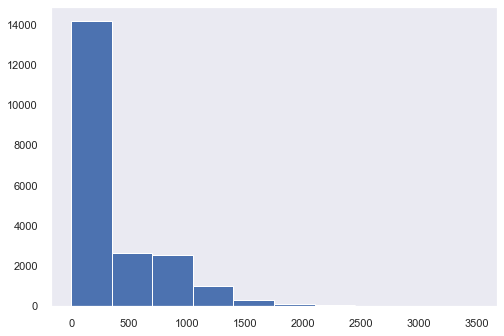

In [132]:
plt.hist(sales_clean['sqft_basement']);

In [283]:
# Add categorical for has a basement or not

basement_list = []
for i in sales_clean['sqft_basement']:
    if i == 0:
        basement_list.append(0)
    else:
        basement_list.append(1)

sales_clean['basement'] = basement_list

In [284]:
# Create bathroom / bedroom categoricals based on size

bathroom_threshold = 3
bedroom_threshold = 4

sales_clean['high_bathrooms'] = 0
sales_clean['high_bathrooms'].loc[sales_clean['bathrooms'] >= bathroom_threshold] = 1

sales_clean['high_bedrooms'] = 0
sales_clean['high_bedrooms'].loc[sales_clean['bedrooms'] >= bedroom_threshold] = 1

In [285]:
# Function for zip code categoricals

zipcodes = []
def zipcode_encoder(df):
    for i in list(set(df['zipcode'])):
        sales_clean.loc[sales_clean['zipcode'] == i, 'zip_' + str(i)] = 1
        sales_clean.loc[sales_clean['zipcode'] != i, 'zip_' + str(i)] = 0
        
        zipcodes.append('zip_' + str(i))

zipcode_encoder(sales_clean)

In [286]:
# Function for building a zip code list with other categoricals

def zipcode_column_builder(df, lst):
    columns = lst
    for i in zipcodes:
        columns.append(str(i))
    return columns

In [46]:
# Add zip code categorical to data frame

pd.set_option('display.max_columns', None)

sales_clean =  pd.concat([sales_clean, zipcode_encoder(sales_clean)], axis=1)

In [47]:
# Append neighborhood categories

zipcode_dict = {98002: 'Auburn',98092: 'Auburn',98224: 'Baring',98004: 'Bellevue',98005: 'Bellevue',
98006: 'Bellevue',98007: 'Bellevue',98008: 'Bellevue',98010: 'Black_Diamond',98011: 'Bothell',
98178: 'Bryn_Mawr_Skyway',98148: 'Burien',98166: 'Burien',98014: 'Carnation',98077: 'Cottage_Lake',
98042: 'Covington',98198: 'Des_Moines',98019: 'Duvall',98031: 'East_Hill_Meridian',98022: 'Enumclaw',
98058: 'Fairwood',98024: 'Fall_City',98003: 'Federal_Way',98023: 'Federal_Way',98027: 'Issaquah',
98029: 'Issaquah',98028: 'Kenmore',98032: 'Kent',98030: 'Kent',98033: 'Kirkland',98034: 'Kirkland',
98001: 'Lakeland_North',98038: 'Maple_Valley',98039: 'Medina',98040: 'Mercer_Island',98045: 'North_Bend',
98047: 'Pacific',98050: 'Preston',98051: 'Ravensdale',98052: 'Redmond',98055: 'Renton',98056: 'Renton',
98057: 'Renton',98059: 'Renton',98074: 'Sammamish',98075: 'Sammamish',98188: 'SeaTac',98199: 'Seattle',
98174: 'Seattle',98154: 'Seattle',98158: 'Seattle',98164: 'Seattle',98101: 'Seattle',98102: 'Seattle',
98103: 'Seattle',98104: 'Seattle',98105: 'Seattle',98106: 'Seattle',98107: 'Seattle',98108: 'Seattle',
98109: 'Seattle',98112: 'Seattle',98115: 'Seattle',98116: 'Seattle',98117: 'Seattle',98118: 'Seattle',
98119: 'Seattle',98121: 'Seattle',98122: 'Seattle',98125: 'Seattle',98126: 'Seattle',98133: 'Seattle',
98134: 'Seattle',98136: 'Seattle',98144: 'Seattle',98155: 'Shoreline',98177: 'Shoreline',98288: 'Skykomish',
98065: 'Snoqualmie',98168: 'Tukwila',98053: 'Union_Hill_Novelty_Hill',98195: 'Univ_Of_Washington',
98070: 'Vashon',98146: 'White_Center',98072: 'Woodinville'}


for i in zipcode_dict.keys():
    sales_clean.loc[sales_clean['zipcode'] == i, 'neighborhood'] = zipcode_dict[i] 

neighborhood_list = list(set(sales_clean['neighborhood']))

for i in neighborhood_list:
    sales_clean.loc[sales_clean['neighborhood'] == i, i] = 1
    sales_clean.loc[sales_clean['neighborhood'] != i, i] = 0

In [48]:
# zipcodes = [str(x) for x in zipcode_dict.keys()]
# zipcode_cols = ['zipcode_' + x for x in zipcodes]

In [49]:
# Drop zipcode columns to clean up dataset and focus only on neighborhoods
# zip_codes_drop = list(range(28,98))

# sales_clean.drop(sales_clean.columns[zip_codes_drop], axis=1, inplace=True)

# sales_clean.head()

### Outliers

In [50]:
len(df_sales[df_sales['bedrooms'] <= 5]) / len(df_sales)
len(df_sales[df_sales['sqft_lot'] <= 200000]) / len(df_sales)
len(df_sales[df_sales['price'] <= 2000000]) / len(df_sales)

0.9908320600083345

In [51]:
# Set thresholds to filter dataset down for outliers
# Drop Medina and Mercer

max_bedrooms = 5
max_sq_ft = 200000
neighborhoods_to_drop = ['Medina', 'Mercer_Island']
zipcodes_to_drop = ['98039', '98040']
sales_clean = sales_clean[sales_clean['bedrooms'] <= max_bedrooms]
sales_clean = sales_clean[sales_clean['sqft_lot'] <= max_sq_ft]
sales_clean = sales_clean[(sales_clean['neighborhood'] != neighborhoods_to_drop[0]) &
                         (sales_clean['neighborhood'] != neighborhoods_to_drop[1])]


neighborhood_list.remove('Medina')
neighborhood_list.remove('Mercer_Island')

### Check for collinearity among independent variables

In [52]:
sales_clean.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view',
       ...
       'Snoqualmie', 'Bellevue', 'Tukwila', 'Maple_Valley', 'Duvall',
       'Fairwood', 'Issaquah', 'Union_Hill_Novelty_Hill', 'Medina',
       'Covington'],
      dtype='object', length=136)

In [53]:
sales_clean_num = sales_clean.select_dtypes(include=['float64', 'int64'])

drop_from_coll = ['id', 'sqft_lot15', 'sqft_living15', 'zipcode', 'view', 'price'] + neighborhood_list

X_multi_coll = sales_clean_num.drop(columns=drop_from_coll
                                             , axis=1)

In [54]:
# fig, ax = plt.subplots(figsize=(15,10))

# sns.heatmap(X_multi_coll.corr(), annot=True, ax=ax)
# plt.show()

# Seems like some of the metrics related to size may be correlated

In [55]:
# Filter for only multicollinearity above a certain threshold

mult_corr = X_multi_coll.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
mult_corr['pairs'] = list(zip(mult_corr.level_0, mult_corr.level_1))

# set index to pairs
mult_corr.set_index(['pairs'], inplace = True)

#d rop level columns
mult_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
mult_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
mult_corr.drop_duplicates(inplace=True)

mult_corr[(mult_corr.cc>.6)] #& (test.cc <1)]

# Conclusions: sqft_living_log is highly correlated with a number of other features.

,cc
pairs,
"(bedrooms, bedrooms)",1.000000
"(yr_renovated, is_renovated)",0.999967
"(two_or_more_stories, floors)",0.915054
"(multi_story, floors)",0.904409
"(sqft_living, sqft_above)",0.873393
"(high_bedrooms, bedrooms)",0.848261
"(two_or_more_stories, multi_story)",0.836841
"(basement, sqft_basement)",0.828726
"(grade, sqft_living)",0.760227


### Log scale of variables

In [56]:
sales_clean['sqft_living_log'] = np.log(sales_clean['sqft_living'])
sales_clean['price_log'] = np.log(sales_clean['price'])

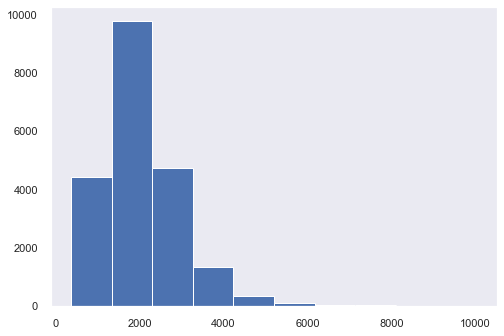

In [57]:
plt.hist(sales_clean['sqft_living']);

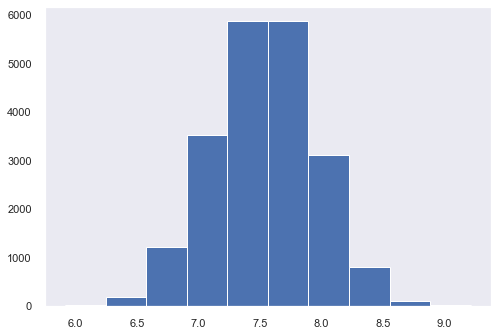

In [58]:
plt.hist(sales_clean['sqft_living_log']);

## Modeling

- Modeling started with a simple model that picked the feature that had the highest correlation with price, square footage of living space
- Iterations will add and subtract certain features to test effect on predictive value
- In addition, new interactive variables will be created based on business hypotheses to test effectiveness vs. price
- Rather than the "kitchen-sink" approach, we wanted variables that would be easy to understand for our stakeholder

In [59]:
# Create the train and test datasets
from sklearn.model_selection import train_test_split

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [60]:
# Filter for only multicollinearity above a certain threshold

mult_corr = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
mult_corr['pairs'] = list(zip(mult_corr.level_0, mult_corr.level_1))

# set index to pairs
mult_corr.set_index(['pairs'], inplace = True)

#d rop level columns
mult_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
mult_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
mult_corr.drop_duplicates(inplace=True)

highly_corr = mult_corr[(mult_corr.cc>.6)] #& (test.cc <1)]

# Conclusions: sqft_living_log is highly correlated with a number of other features.

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- Model-less prediction is just taking the average home price across all observation
- This "prediction" is 216K off from the actual home price on average

In [61]:
# Linear reegression imports

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

In [62]:
train_target_mean = y_train.mean()

In [63]:
baseline_train_preds = [train_target_mean] * len(y_train)
baseline_test_preds = [train_target_mean] * len(y_test)

In [64]:
# R squared
print('Model fit for training data')
print(f"R2: {metrics.r2_score(y_train, baseline_train_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_train, baseline_train_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_train, baseline_train_preds):,.0f}")
print("\n")

# R squared
print('Model fit for test data')
print(f"R2: {metrics.r2_score(y_test, baseline_test_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_test, baseline_test_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_test, baseline_test_preds):,.0f}")


Model fit for training data
R2: 0.00
MSE: 331,090
MAE: 216,687


Model fit for test data
R2: -0.00
MSE: 337,813
MAE: 219,914


### Simple model

- The first simple model tests price against it's most correlated feature, which is sqft_living
- This model actually produces a half decent result, with an R2 of 0.5, however, it violates many of the assumptions of linear regression

In [65]:
df_train.corr().price.sort_values(ascending=False)

price              1.000000
price_log          0.901587
sqft_living        0.685284
grade              0.661800
sqft_living_log    0.603508
                     ...   
Federal_Way       -0.138685
zip_98039               NaN
zip_98040               NaN
Mercer_Island           NaN
Medina                  NaN
Name: price, Length: 135, dtype: float64

Train R2: 0.470
Test R2: 0.473
****
Train RMSE: 241,125
Test RMSE: 245,181
****
Train MAE: 162,913
Test MAE: 164,097

Residual scatter plot:


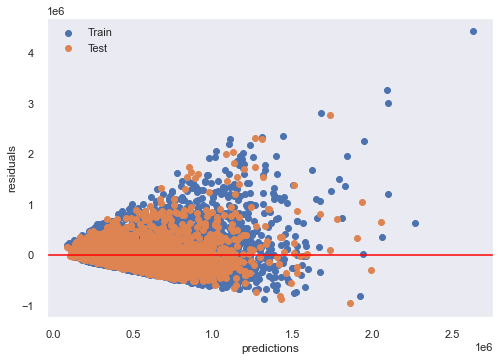



Residual qq plot


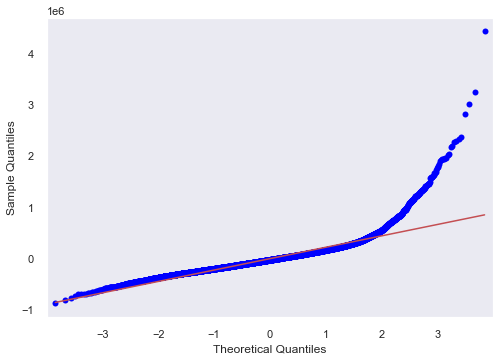

In [66]:
evaluate_model(df_train, df_test, ['sqft_living'], False)

## Modeling Iterations

In [67]:
# Recursive feature selection

# lr_rfe = LinearRegression()
# select = RFE(lr_rfe, n_features_to_select=5)

# ss = StandardScaler()
# ss.fit(df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1))

# train_scaled = ss.transform(df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1))

# select.fit(X=train_scaled, y=df_train['price'])

# select.support_

# select.ranking_

In [68]:
# ranked = list(zip(select.ranking_,df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1).columns))

### Log transformation of living area square feet and price

Train R2: 0.433
Test R2: 0.448
****
Train RMSE: 255,940
Test RMSE: 259,939
****
Train MAE: 159,942
Test MAE: 160,890

Residual scatter plot:


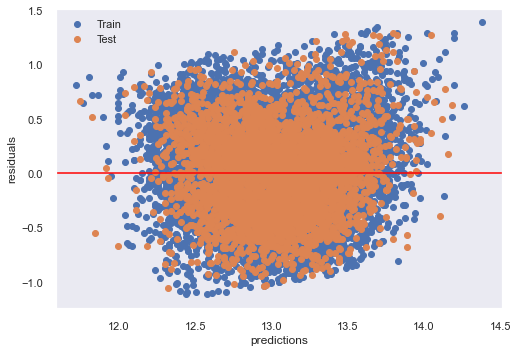



Residual qq plot


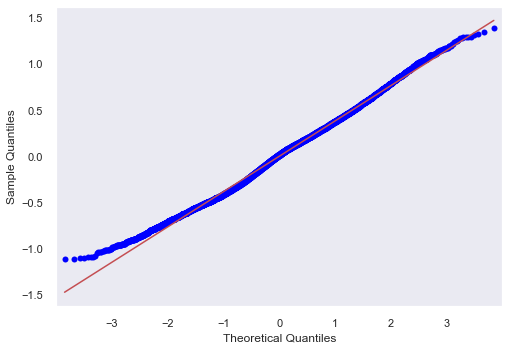

In [69]:
evaluate_model(df_train, df_test, ['sqft_living_log'], True)

### Various iterations of housing features

In [70]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from statsmodels.formula.api import ols
import statsmodels.api as sm

Train R2: 0.500
Test R2: 0.506
****
Train RMSE: 229,770
Test RMSE: 233,430
****
Train MAE: 147,080
Test MAE: 148,629

Residual scatter plot:


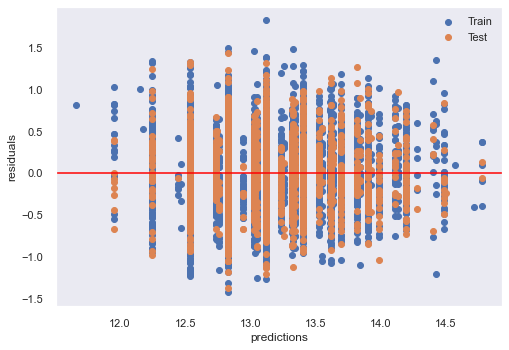



Residual qq plot


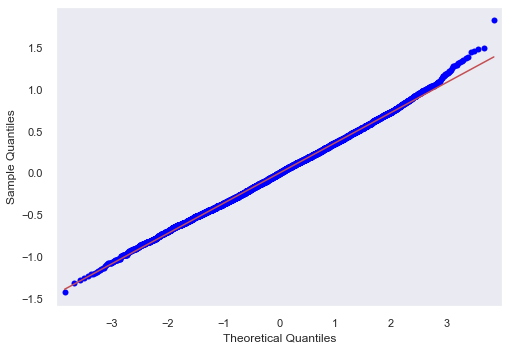

In [71]:
# Replace sqft_living_log with other versions of size

cols1 = ['high_bathrooms', 'grade', 'recent_build', 'is_renovated']

model_output1, train_preds1, test_preds1 = run_model(df_train, df_test, cols1, True)

evaluate_model(df_train, df_test, cols1, True)

Train R2: 0.506
Test R2: 0.516
****
Train RMSE: 229,882
Test RMSE: 232,612
****
Train MAE: 146,478
Test MAE: 147,406

Residual scatter plot:


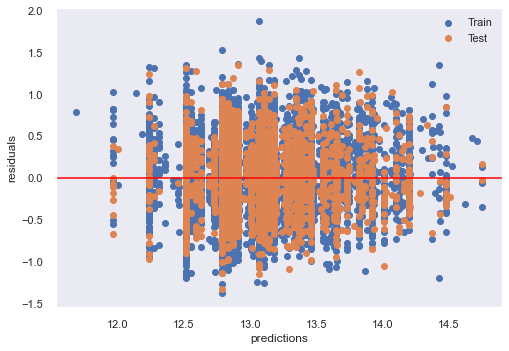



Residual qq plot


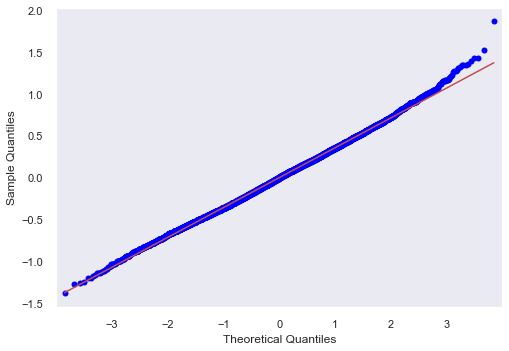

In [72]:
cols2 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'recent_build', 'is_renovated']

model_output2, train_preds2, test_preds2 = run_model(df_train, df_test, cols2, True)

evaluate_model(df_train, df_test, cols2, True)

Train R2: 0.508
Test R2: 0.516
****
Train RMSE: 228,093
Test RMSE: 231,195
****
Train MAE: 145,682
Test MAE: 146,936

Residual scatter plot:


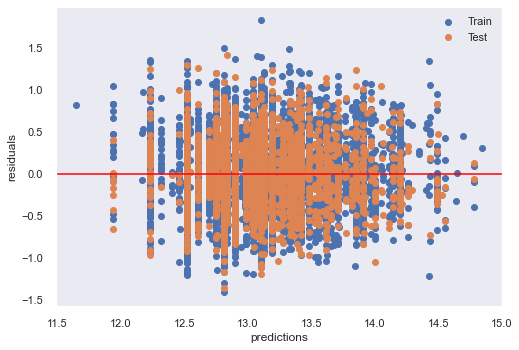



Residual qq plot


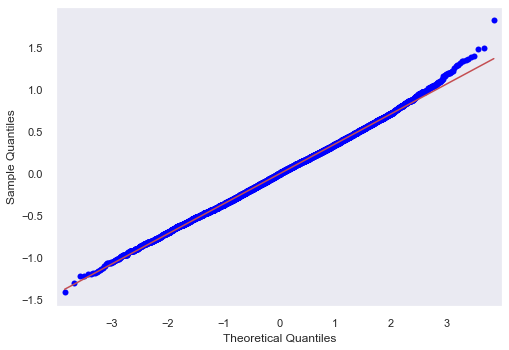

In [73]:
cols3 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'is_renovated']

model_output3, train_preds3, test_preds3 = run_model(df_train, df_test, cols3, True)

evaluate_model(df_train, df_test, cols3, True)

Train R2: 0.523
Test R2: 0.529
****
Train RMSE: 225,789
Test RMSE: 228,275
****
Train MAE: 143,075
Test MAE: 145,192

Residual scatter plot:


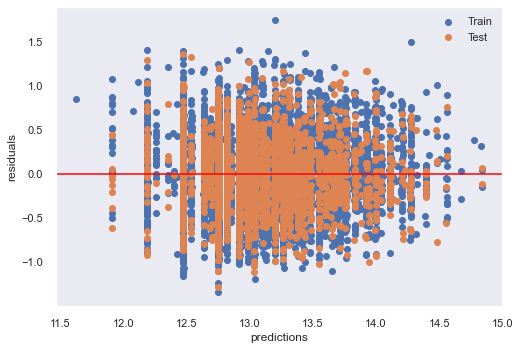



Residual qq plot


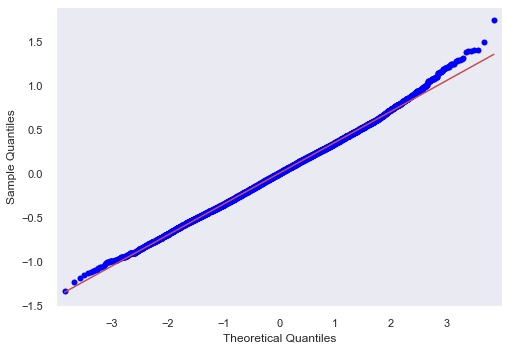

In [74]:
cols4 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'basement']

model_output4, train_preds4, test_preds4 = run_model(df_train, df_test, cols4, True)

evaluate_model(df_train, df_test, cols4, True)

### Create interaction variables and use neighborhood

In [75]:
neighborhood_df = pd.DataFrame(df_train.groupby(by='neighborhood')['price'].agg(['mean', 'count']))

neighborhood_df['avg_price'] = df_train['price'].mean()
neighborhood_df['price_delta'] = abs(neighborhood_df['mean'] - neighborhood_df['avg_price'])

neighborhood_df.sort_values(by='price_delta')

# Comments: I'm choosing to remove Snoqualmie as it has the best combination of largest and closest to mean

,mean,count,avg_price,price_delta
neighborhood,,,,
Snoqualmie,521061.298755,241,520264.767126,796.531629
Shoreline,502208.862007,558,520264.767126,18055.905119
Bothell,491975.425806,155,520264.767126,28289.341319
Fall_City,485767.500000,50,520264.767126,34497.267126
Woodinville,566019.860577,208,520264.767126,45755.093451
Seattle,571852.602382,5289,520264.767126,51587.835257
Vashon,467354.829268,82,520264.767126,52909.937857
Kenmore,464460.933921,227,520264.767126,55803.833205
Issaquah,609635.207207,555,520264.767126,89370.440081


In [76]:
# Create new variable for sqft of ground floor vs. lot size. Do the same for neighboring properties
sales_clean['living_area_vs_lot'] = (sales_clean['sqft_above'] / sales_clean['floors']) / sales_clean['sqft_lot']
sales_clean['size_vs_lot_log'] = np.log(sales_clean['living_area_vs_lot'])
sales_clean['neighbor_size_vs_lot'] = sales_clean['sqft_living15'] / sales_clean['sqft_lot15']

# Log sqft living for closest 15 neighbors
sales_clean['sqft_living15_log'] = np.log(sales_clean['sqft_living15'])

In [77]:
# Create new variable for relative number of bathrooms vs. bedrooms
sales_clean['bath_vs_bed'] = sales_clean['bathrooms'] / sales_clean['bedrooms']
sales_clean['bath_vs_bed_log'] = np.log(sales_clean['bath_vs_bed'])

In [78]:
sales_clean['living_area_vs_lot'].loc[sales_clean['living_area_vs_lot'] >= 1] = 1

In [79]:
# New categorical variable, estimating whether a property has a yard or doesn't.
yard_threshold = 0.3
sales_clean['has_yard'] = 0
sales_clean['has_yard'].loc[sales_clean['living_area_vs_lot'] <= yard_threshold] = 1

In [80]:
# New categorical variable for prewar, midcentury, or post war construction
sales_clean.drop(columns=['recent_build'], axis=1, inplace=True)

prewar = 1970
recent_build = 2010

sales_clean['pre_1970'] = 0 
sales_clean['mid_century'] = 0
sales_clean['recent_build'] = 0

sales_clean['pre_1970'].loc[sales_clean['yr_built'] < prewar] = 1
sales_clean['mid_century'].loc[(sales_clean['yr_built'] >= prewar) & (sales_clean['yr_built'] < recent_build)] = 1
sales_clean['recent_build'].loc[sales_clean['yr_built'] >= recent_build] = 1

In [81]:
# Interactive variable between pre_war and is_renovated

sales_clean['pre_1970_renovated'] = sales_clean['pre_1970'] * sales_clean['is_renovated']

In [82]:
# New train / test split based on the above changes

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [83]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98198,zip_98070,zip_98199,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98005,zip_98007,zip_98136,zip_98008,zip_98010,zip_98168,zip_98006,zip_98011,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98155,zip_98032,zip_98033,zip_98034,zip_98031,zip_98038,zip_98166,zip_98040,zip_98042,zip_98045,neighborhood,Renton,Black_Diamond,Lakeland_North,Redmond,Kenmore,Cottage_Lake,Shoreline,Vashon,Sammamish,Kirkland,SeaTac,East_Hill_Meridian,Federal_Way,White_Center,Kent,Auburn,Fall_City,Enumclaw,Bothell,Des_Moines,North_Bend,Seattle,Bryn_Mawr_Skyway,Mercer_Island,Burien,Woodinville,Carnation,Snoqualmie,Bellevue,Tukwila,Maple_Valley,Duvall,Fairwood,Issaquah,Union_Hill_Novelty_Hill,Medina,Covington,sqft_living_log,price_log,living_area_vs_lot,size_vs_lot_log,neighbor_size_vs_lot,sqft_living15_log,bath_vs_bed,bath_vs_bed_log,has_yard,pre_1970,mid_century,recent_build,pre_1970_renovated,price
17729,6/13/2014,4,2.5,2790,43091,2.0,0.0,0.0,4,9,2790,0.0,1989,0.0,98077,47.7759,-122.080,2750,35290,0,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cottage_Lake,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.933797,13.407542,0.032373,-3.430420,0.077926,7.919356,0.625000,-0.470004,1,0,1,0,0,665000.0
3467,5/13/2014,5,2.5,3001,5710,2.0,0.0,0.0,3,8,3001,0.0,2006,0.0,98042,47.3727,-122.177,2340,5980,0,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Covington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.006701,12.829334,0.262785,-1.336421,0.391304,7.757906,0.500000,-0.693147,1,0,1,0,0,373000.0
18509,9/25/2014,3,1.0,1350,14212,1.0,0.0,0.0,4,6,1350,0.0,1981,0.0,98053,47.6606,-122.060,1520,14404,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Union_Hill_Novelty_Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.207860,12.721886,0.094990,-2.353982,0.105526,7.326466,0.333333,-1.098612,1,0,1,0,0,335000.0
13416,6/27/2014,3,2.5,1060,1536,2.0,0.0,0.0,3,8,1060,0.0,2000,0.0,98117,47.6907,-122.395,1220,1316,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.

Train R2: 0.730
Test R2: 0.738
****
Train RMSE: 192,347
Test RMSE: 197,812
****
Train MAE: 108,476
Test MAE: 110,974

Residual scatter plot:


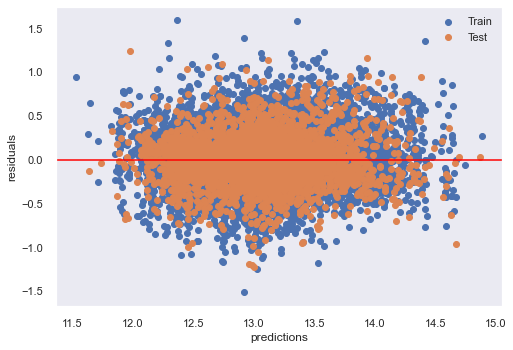



Residual qq plot


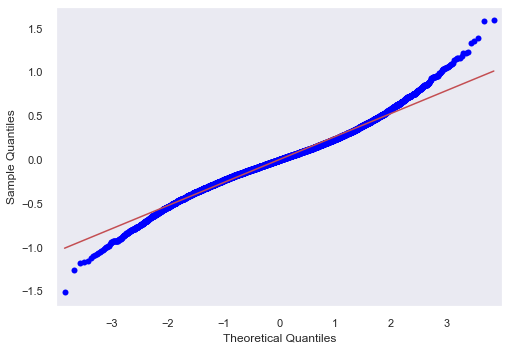

In [84]:
cols5 = ['high_bathrooms', 'high_bedrooms', 'multi-story', 'grade', 'recent_build', 'basement',
        'living_area_vs_lot'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output5, train_preds5, test_preds5 = run_model(df_train, df_test, cols5, True)

evaluate_model(df_train, df_test, cols5, True)

Train R2: 0.759
Test R2: 0.770
****
Train RMSE: 187,694
Test RMSE: 192,300
****
Train MAE: 103,988
Test MAE: 105,995

Residual scatter plot:


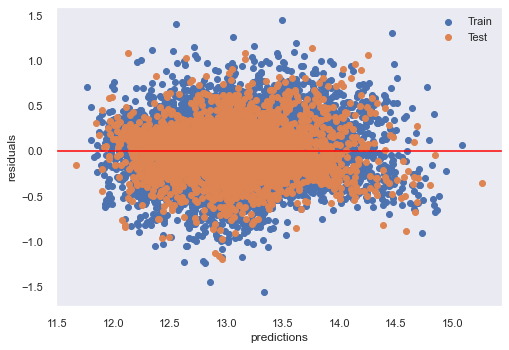



Residual qq plot


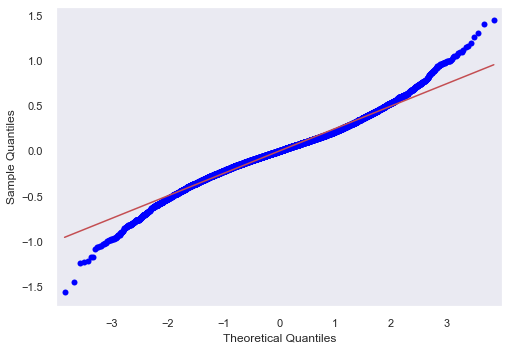

In [85]:
cols6 = cols5 + ['bath_vs_bed', 'sqft_living15']

model_output6, train_preds6, test_preds6 = run_model(df_train, df_test, cols6, True)

evaluate_model(df_train, df_test, cols6, True)

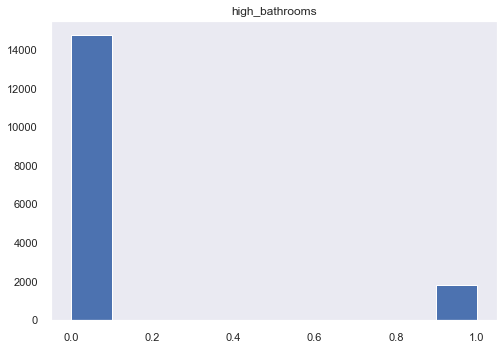

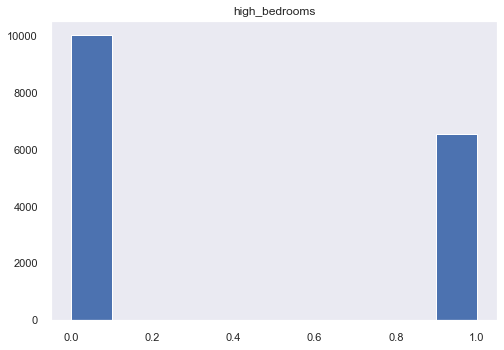

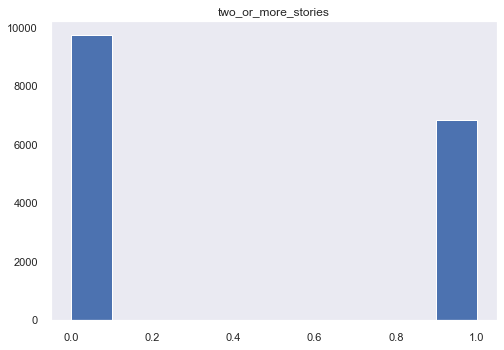

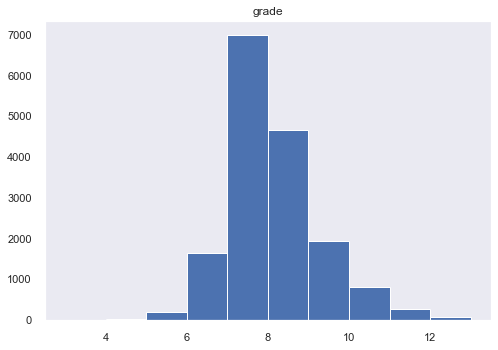

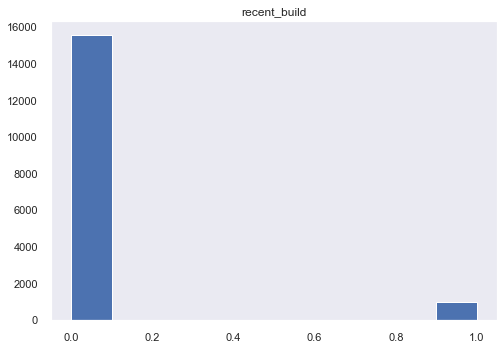

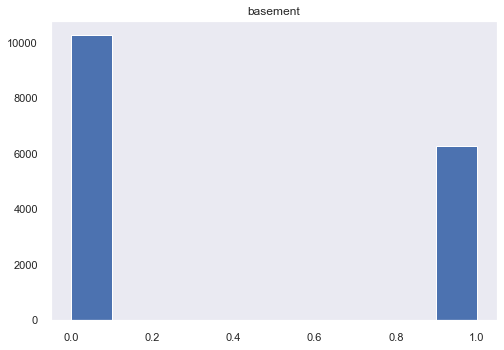

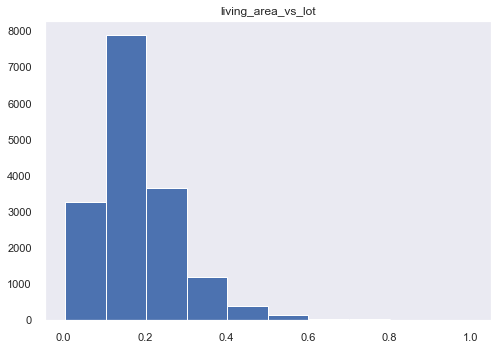

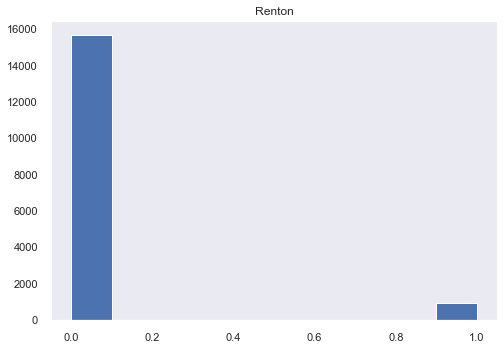

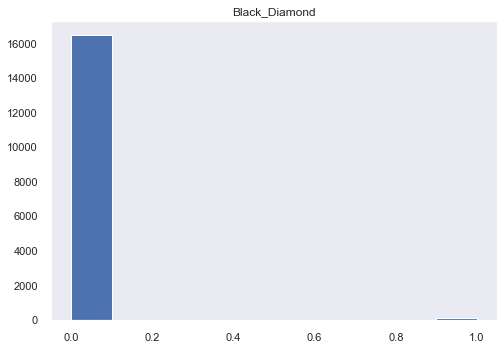

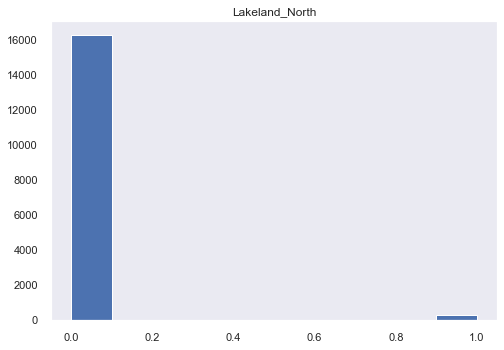

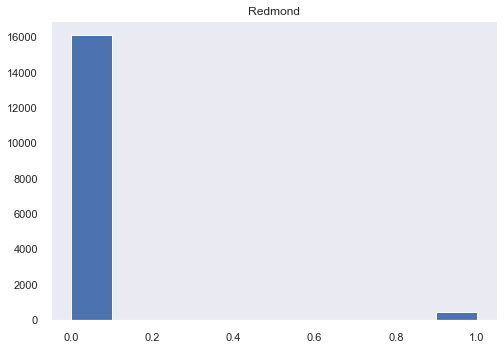

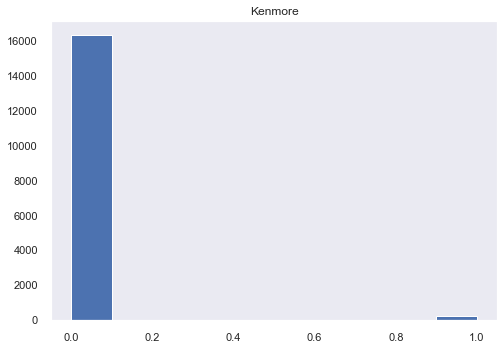

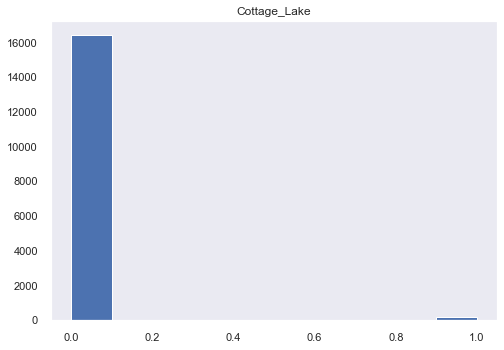

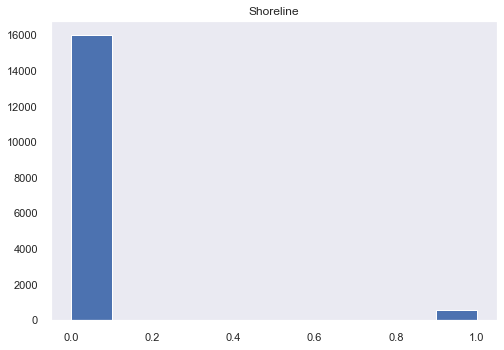

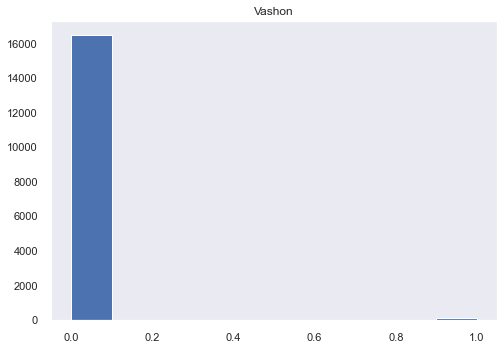

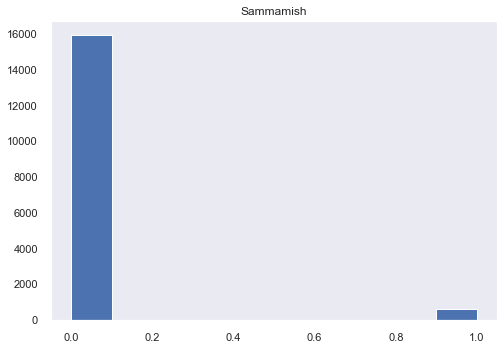

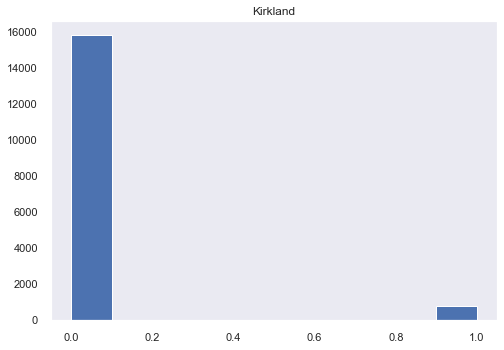

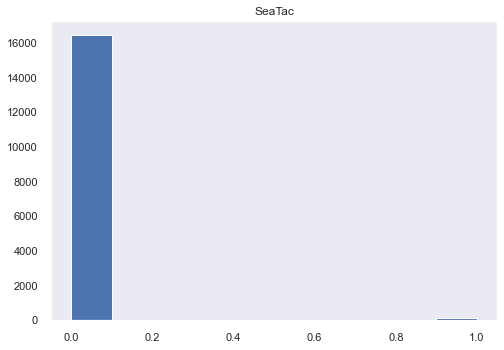

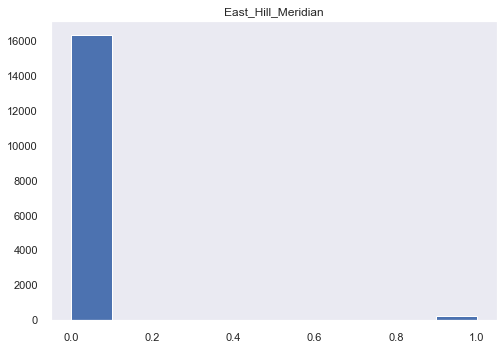

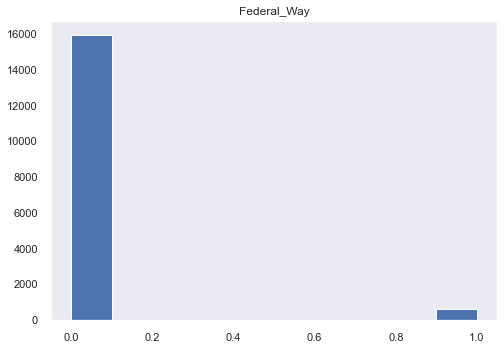

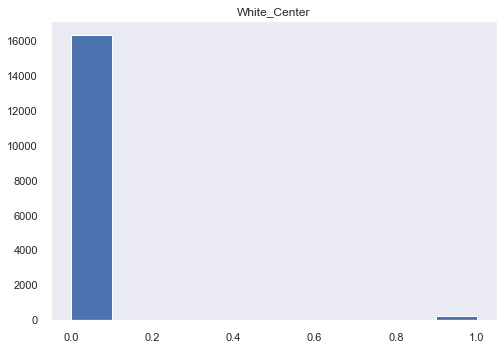

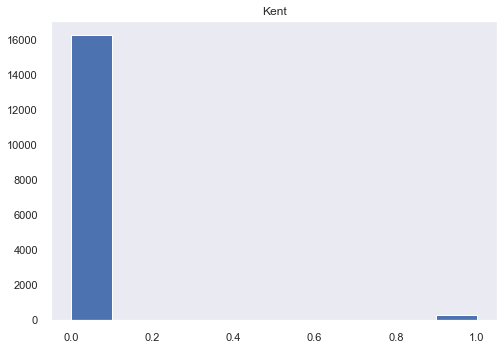

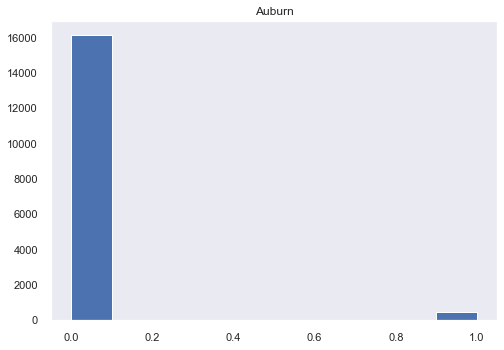

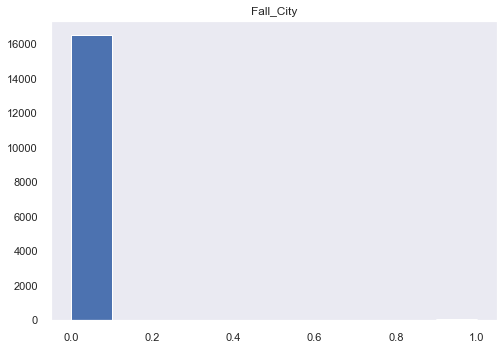

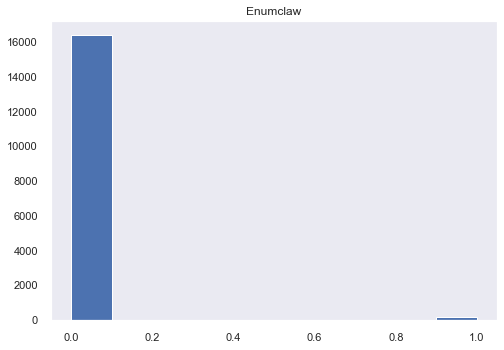

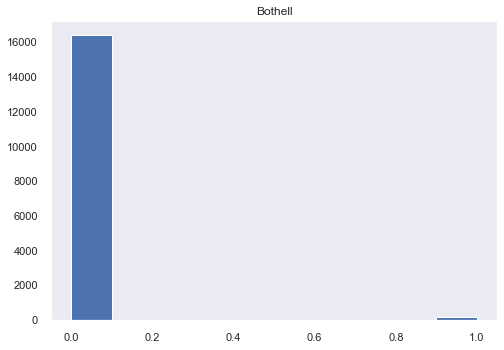

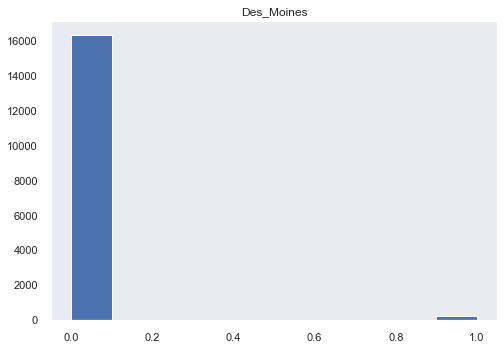

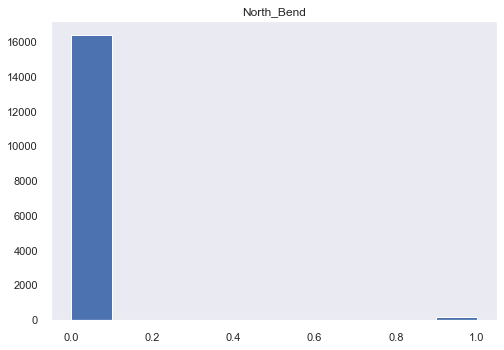

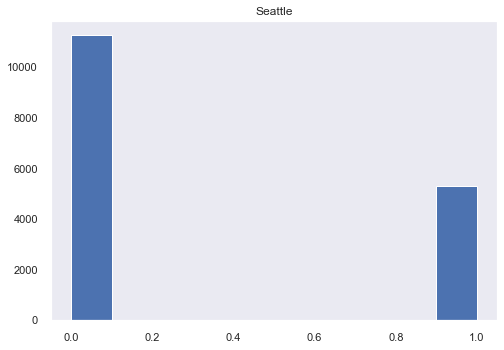

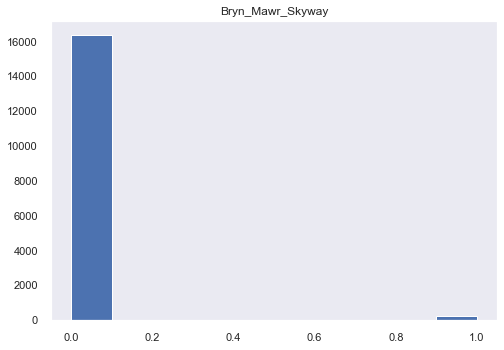

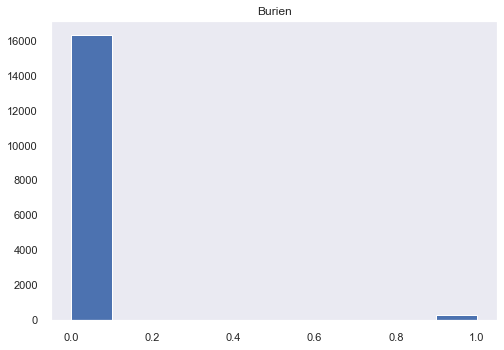

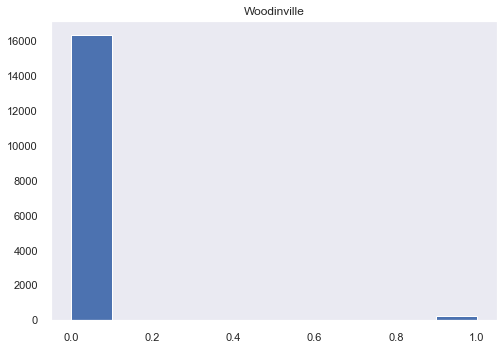

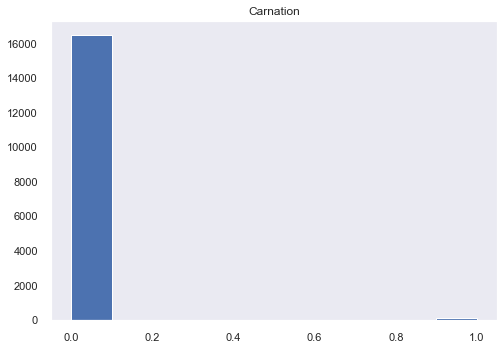

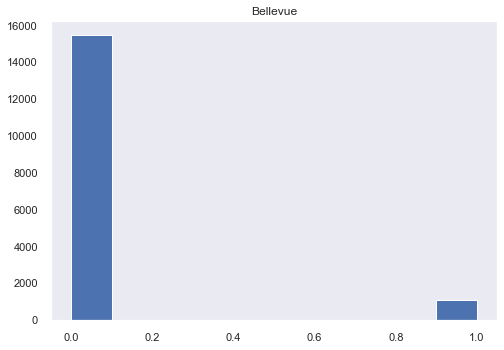

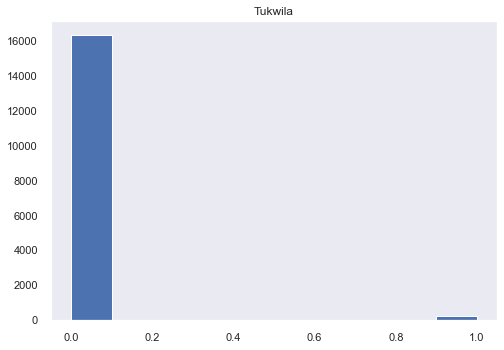

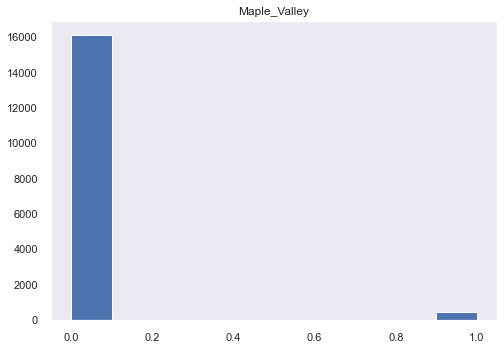

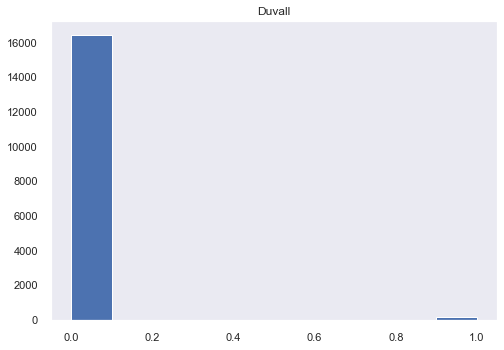

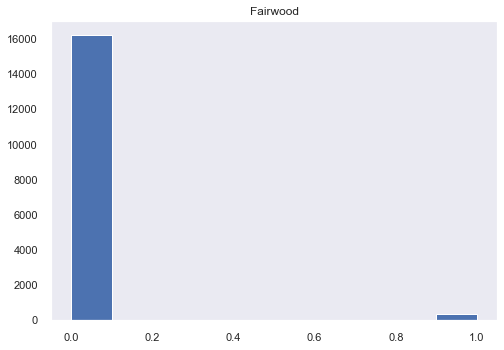

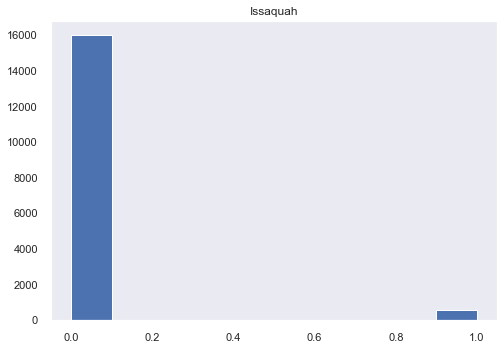

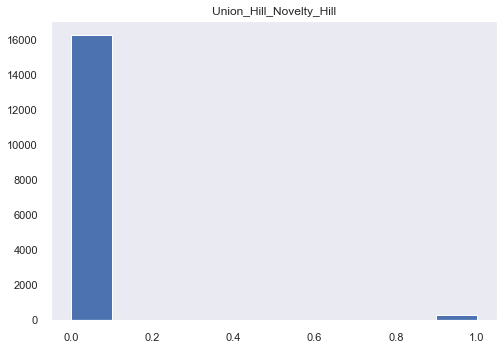

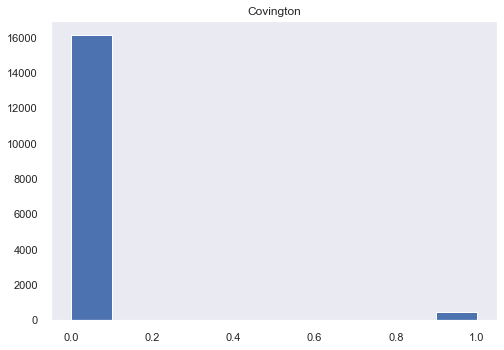

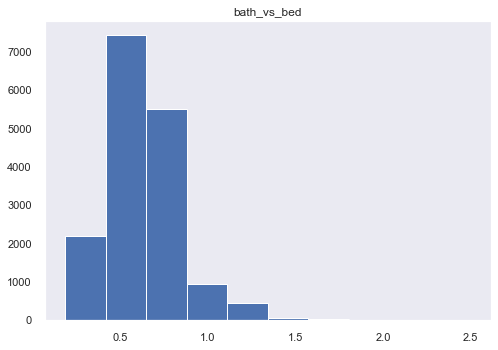

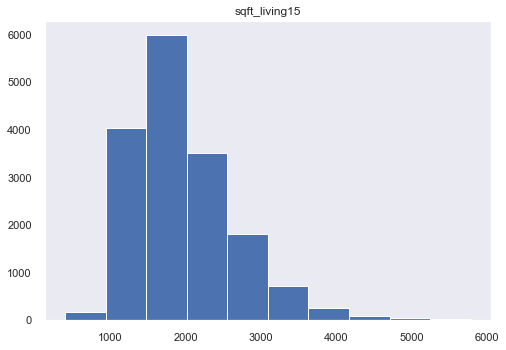

In [86]:
for col in cols6:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show();
    
# There's a normality issue with a few of the independent variables

In [87]:
df_train.head(1)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98198,zip_98070,zip_98199,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98005,zip_98007,zip_98136,zip_98008,zip_98010,zip_98168,zip_98006,zip_98011,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98155,zip_98032,zip_98033,zip_98034,zip_98031,zip_98038,zip_98166,zip_98040,zip_98042,zip_98045,neighborhood,Renton,Black_Diamond,Lakeland_North,Redmond,Kenmore,Cottage_Lake,Shoreline,Vashon,Sammamish,Kirkland,SeaTac,East_Hill_Meridian,Federal_Way,White_Center,Kent,Auburn,Fall_City,Enumclaw,Bothell,Des_Moines,North_Bend,Seattle,Bryn_Mawr_Skyway,Mercer_Island,Burien,Woodinville,Carnation,Snoqualmie,Bellevue,Tukwila,Maple_Valley,Duvall,Fairwood,Issaquah,Union_Hill_Novelty_Hill,Medina,Covington,sqft_living_log,price_log,living_area_vs_lot,size_vs_lot_log,neighbor_size_vs_lot,sqft_living15_log,bath_vs_bed,bath_vs_bed_log,has_yard,pre_1970,mid_century,recent_build,pre_1970_renovated,price
17729,6/13/2014,4,2.5,2790,43091,2.0,0.0,0.0,4,9,2790,0.0,1989,0.0,98077,47.7759,-122.08,2750,35290,0,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cottage_Lake,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.933797,13.407542,0.032373,-3.43042,0.077926,7.919356,0.625,-0.470004,1,0,1,0,0,665000.0


Train R2: 0.763
Test R2: 0.774
****
Train RMSE: 185,718
Test RMSE: 188,520
****
Train MAE: 102,101
Test MAE: 103,604

Residual scatter plot:


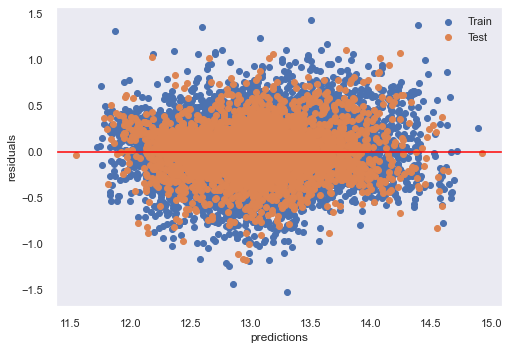



Residual qq plot


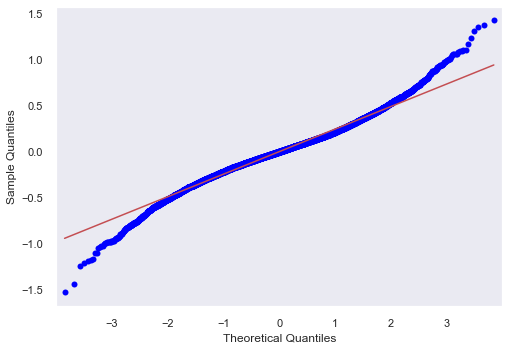

In [88]:
# Use latest col6 but replace with log values
cols7 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'basement',
        'size_vs_lot_log', 'bath_vs_bed', 'sqft_living15_log'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output7, train_preds7, test_preds7 = run_model(df_train, df_test, cols7, True)

evaluate_model(df_train, df_test, cols7, True)

In [89]:
col7_coll_test = df_train[cols7]

high_corr_values = high_corr(col7_coll_test, 0.6)

high_corr_values

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.000000
"(grade, sqft_living15_log)",0.686592


Train R2: 0.768
Test R2: 0.779
****
Train RMSE: 182,098
Test RMSE: 186,003
****
Train MAE: 100,755
Test MAE: 101,866

Residual scatter plot:


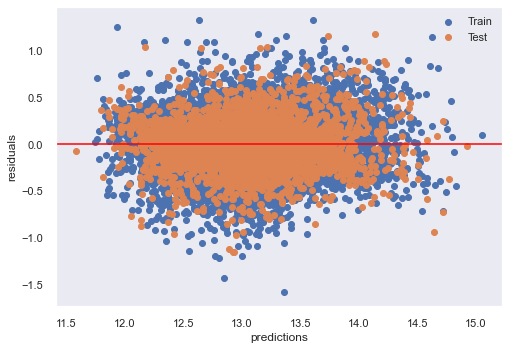



Residual qq plot


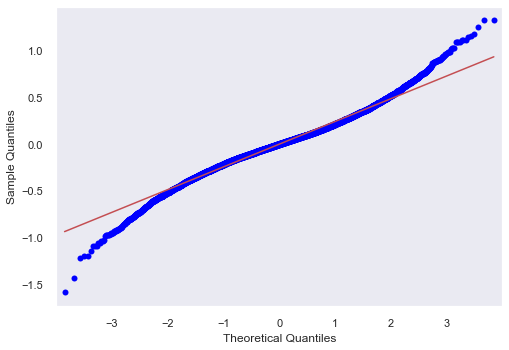

In [90]:
# Add in square footage of the basement

cols8 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'recent_build', 'basement',
        'size_vs_lot_log', 'bath_vs_bed_log', 'sqft_living15_log', 'sqft_basement'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output8, train_preds8, test_preds8 = run_model(df_train, df_test, cols8, True)

evaluate_model(df_train, df_test, cols8, True)

In [91]:
df_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade',
       ...
       'neighbor_size_vs_lot', 'sqft_living15_log', 'bath_vs_bed',
       'bath_vs_bed_log', 'has_yard', 'pre_1970', 'mid_century',
       'recent_build', 'pre_1970_renovated', 'price'],
      dtype='object', length=147)

Train R2: 0.806
Test R2: 0.814
****
Train RMSE: 167,935
Test RMSE: 172,427
****
Train MAE: 91,199
Test MAE: 92,461

Residual scatter plot:


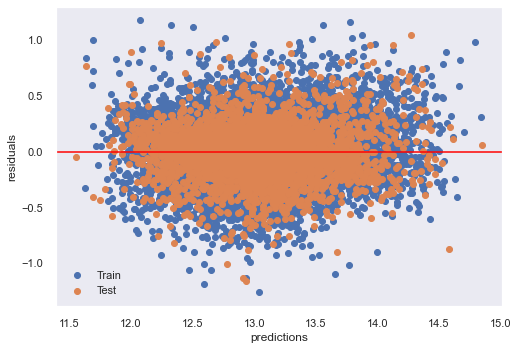



Residual qq plot


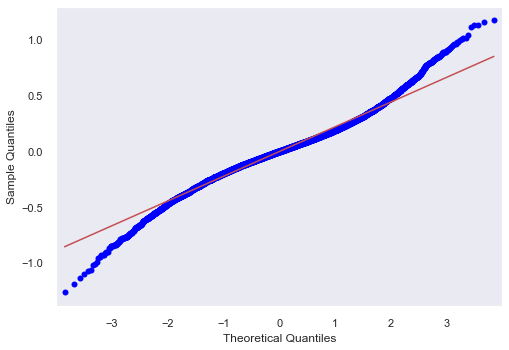

In [92]:
# Add in yard variable, year built categoricals (minus mid century), and interaction between pre 1970 and renovated

cols9 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'basement', 'condition',
        'size_vs_lot_log', 'bath_vs_bed_log', 'sqft_living15_log', 'has_yard', 'pre_1970', 
        'recent_build', 'pre_1970_renovated', 'sqft_living_log'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output9, train_preds9, test_preds9 = run_model(df_train, df_test, cols9, True)

evaluate_model(df_train, df_test, cols9, True)

In [93]:
col9_coll_test = df_train[cols9]

high_corr_values = high_corr(col9_coll_test, 0.6)

high_corr_values

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.000000
"(sqft_living15_log, sqft_living_log)",0.750742
"(sqft_living_log, grade)",0.736981
"(sqft_living15_log, grade)",0.686592


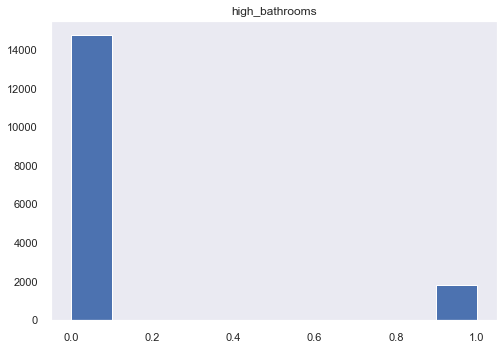

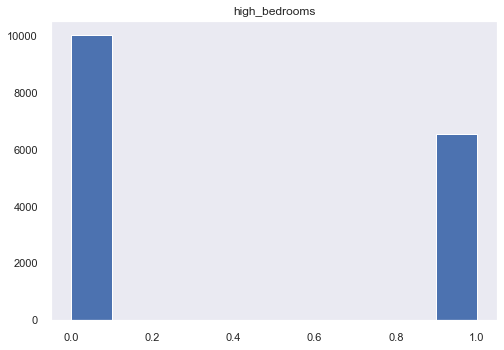

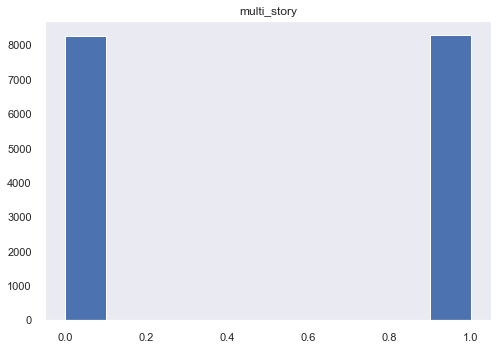

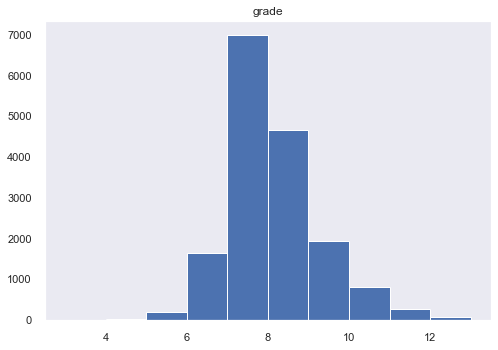

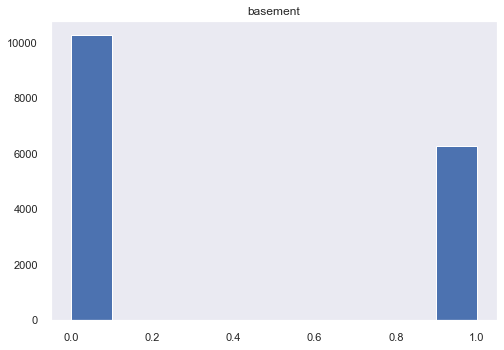

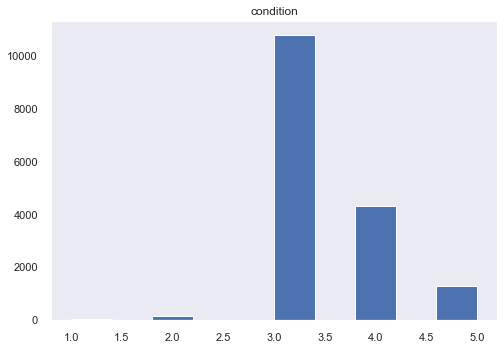

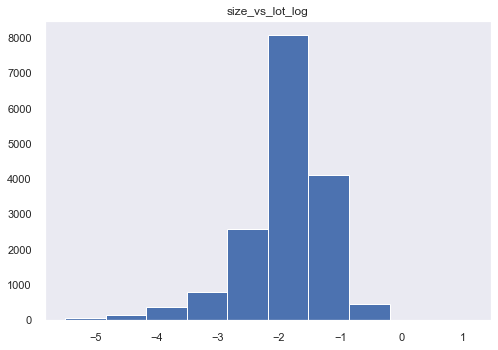

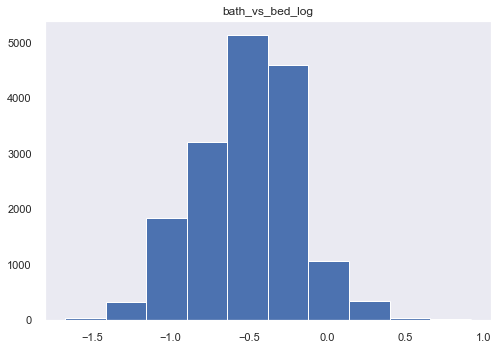

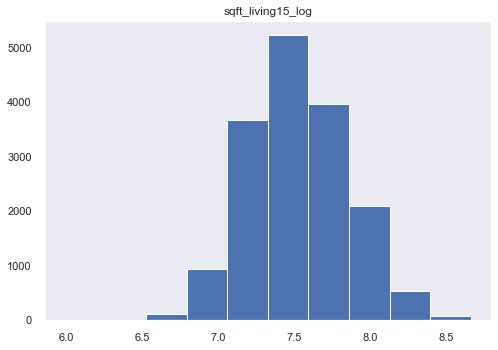

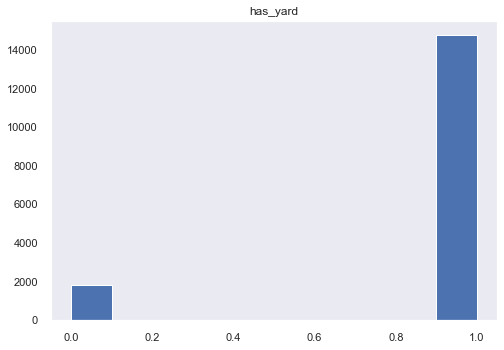

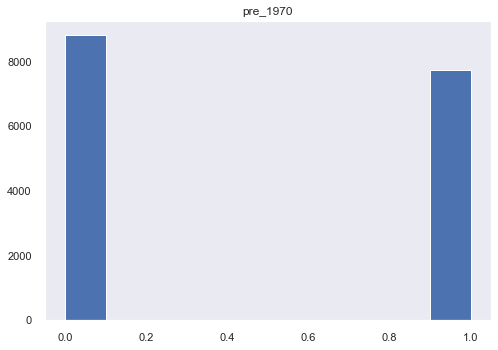

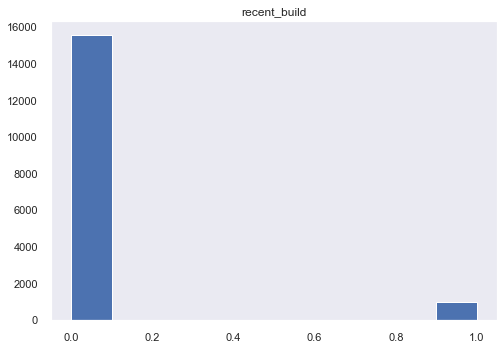

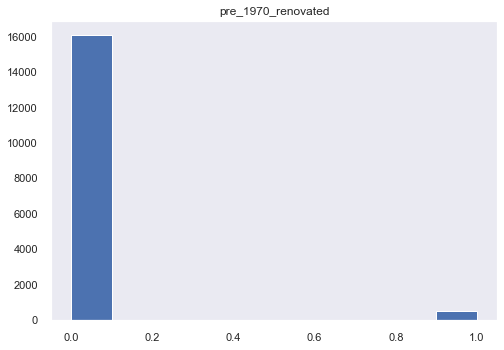

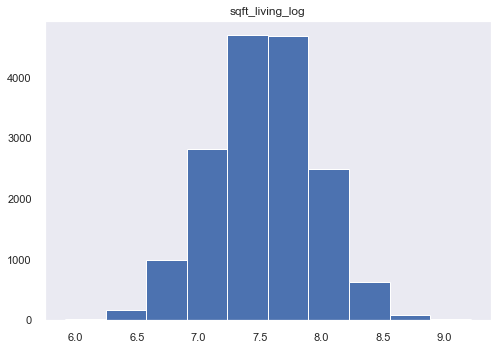

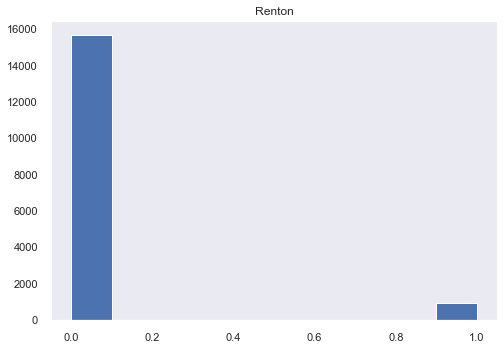

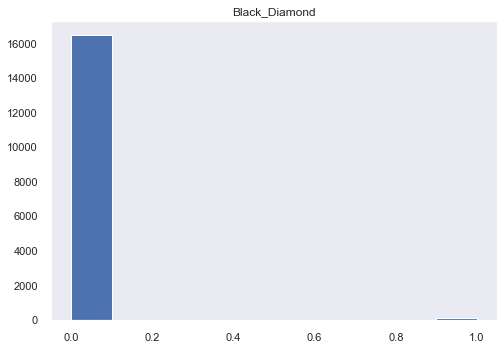

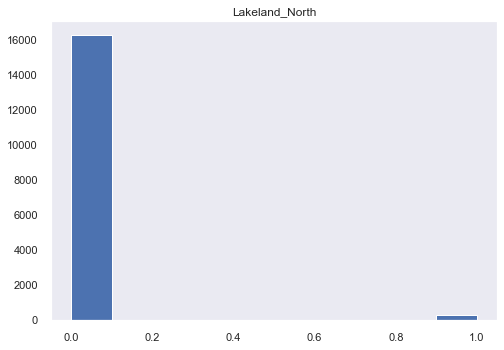

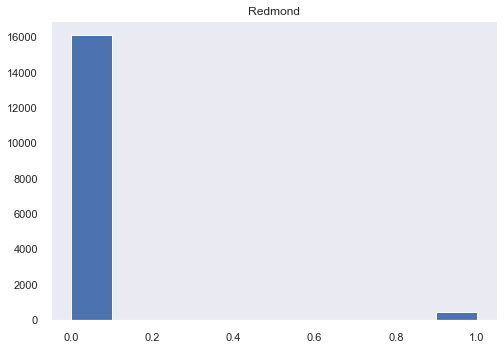

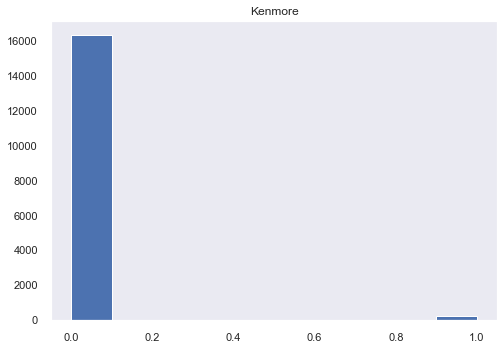

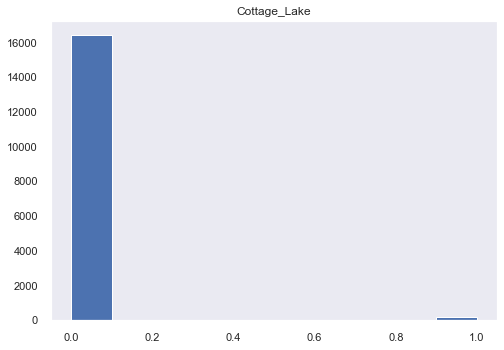

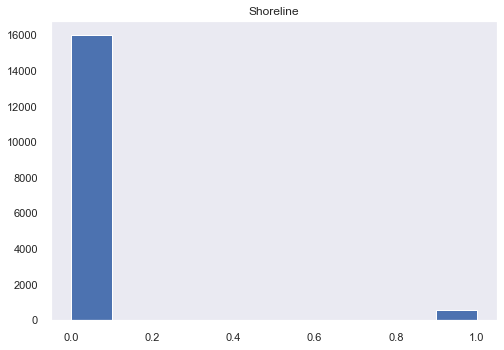

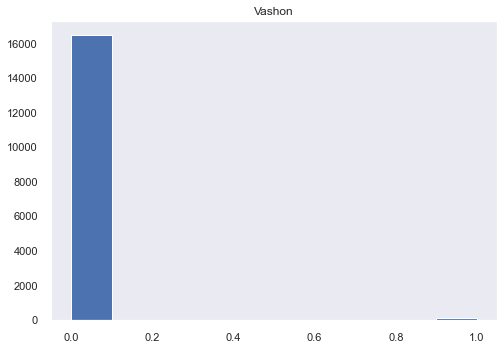

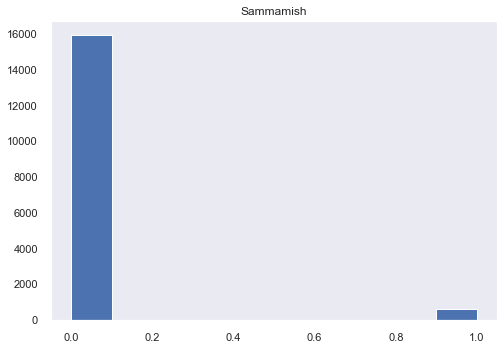

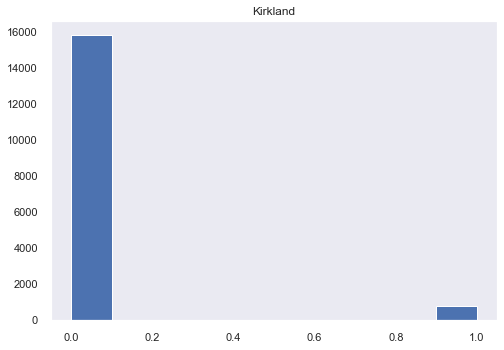

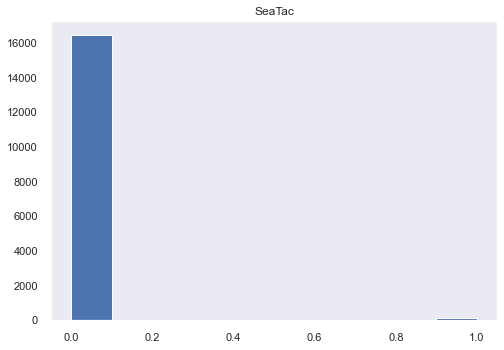

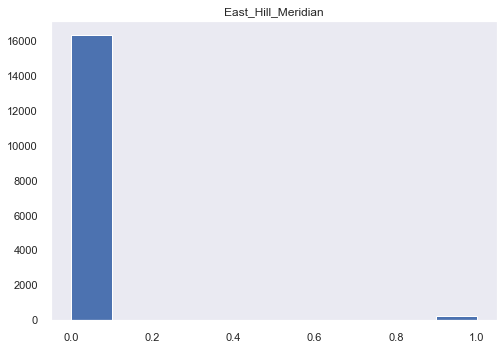

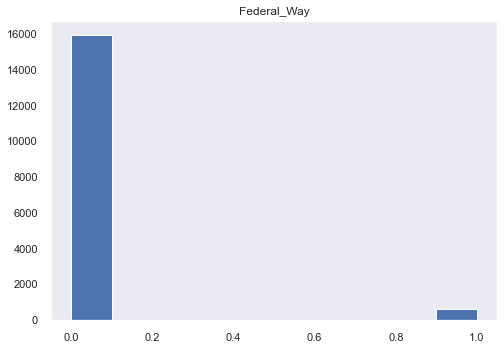

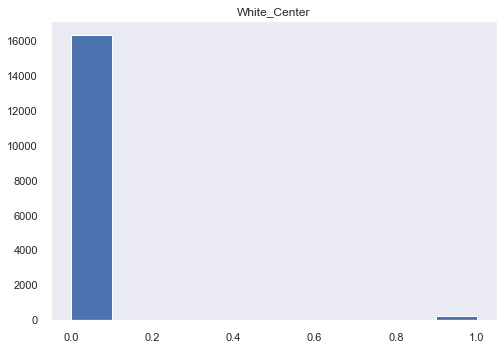

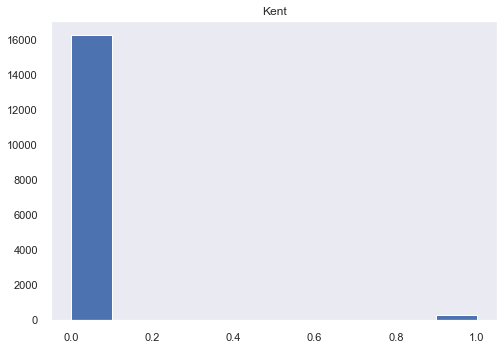

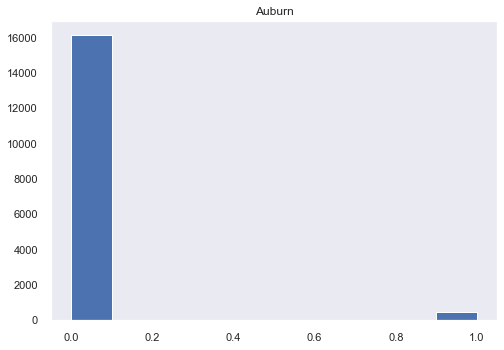

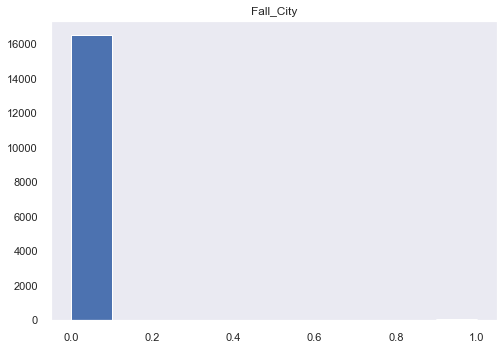

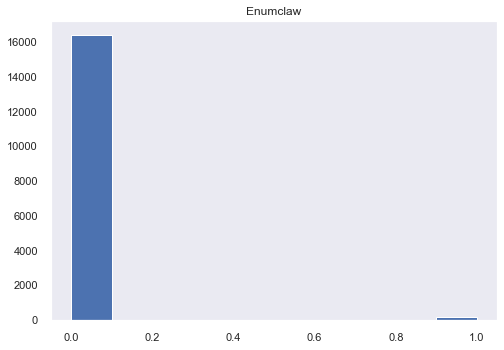

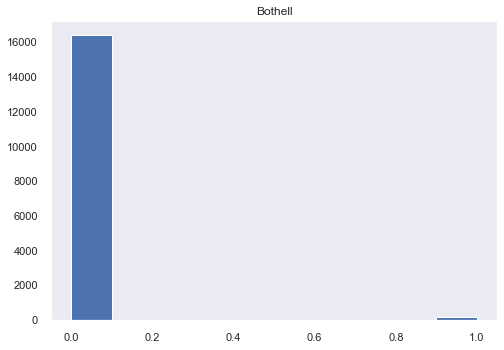

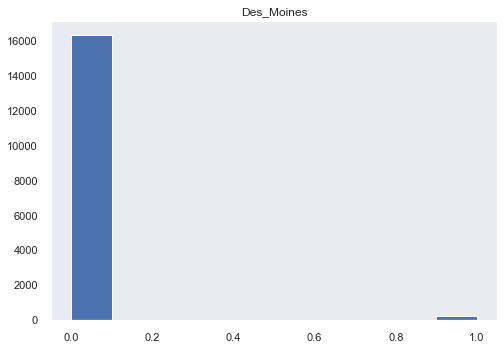

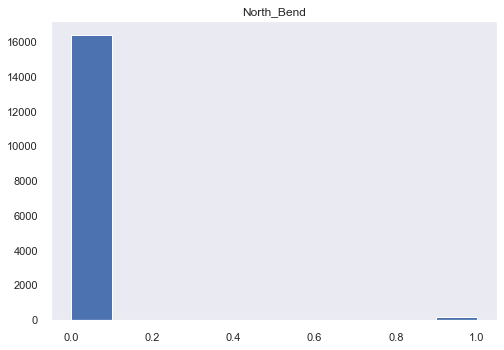

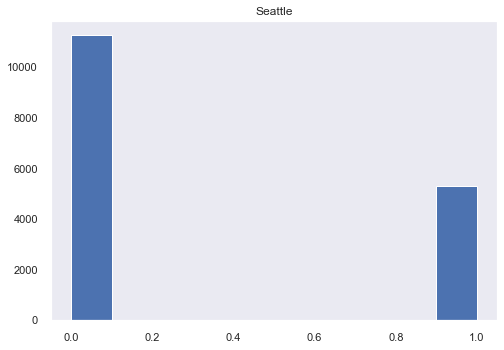

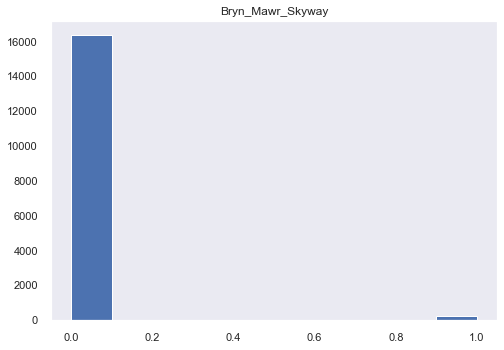

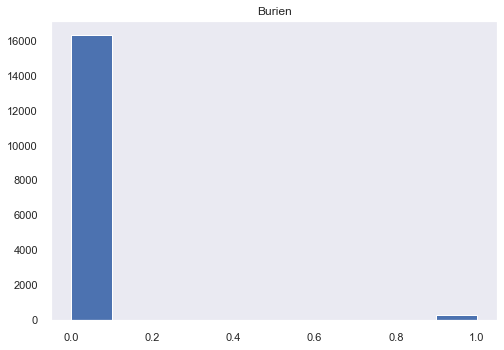

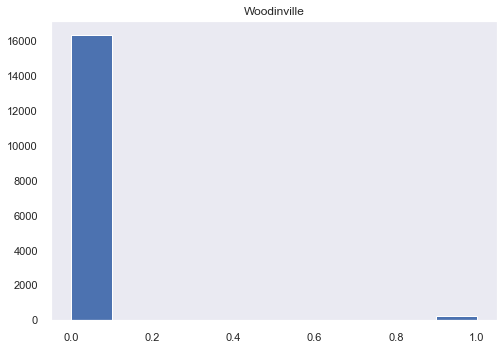

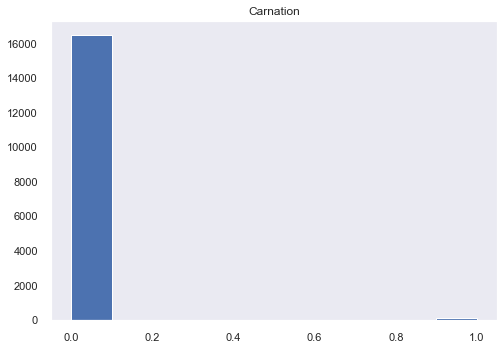

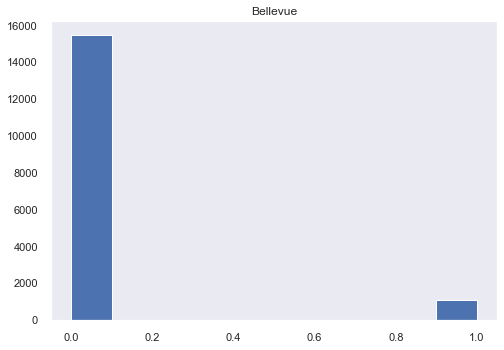

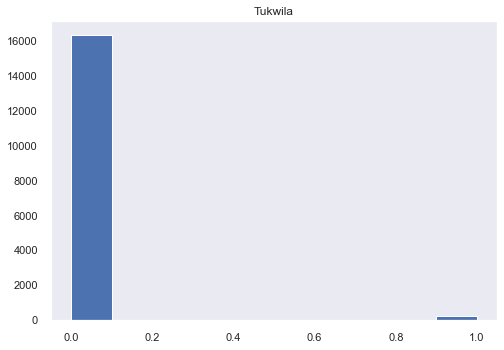

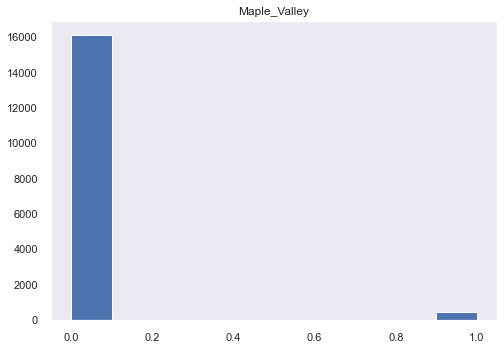

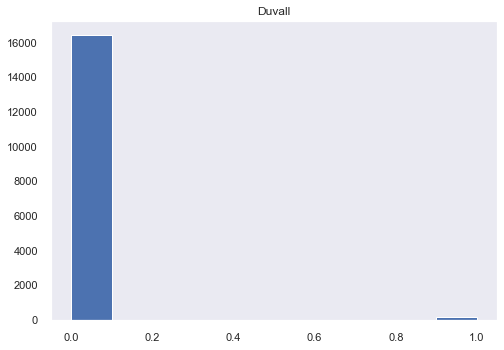

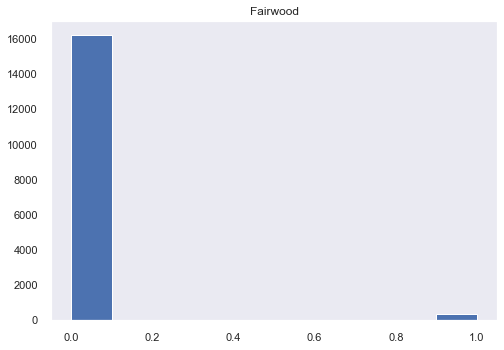

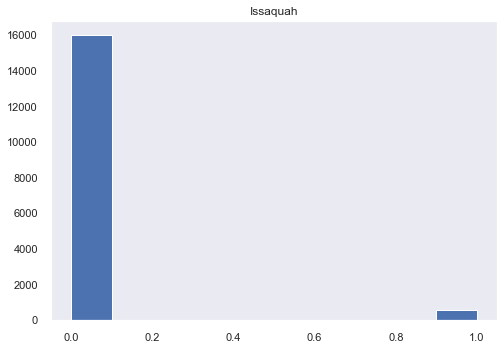

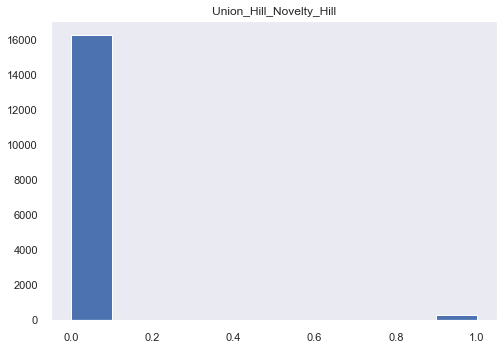

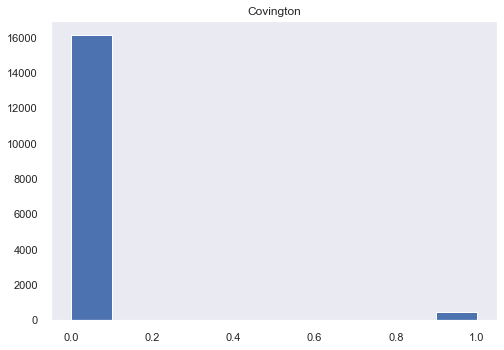

In [94]:
# Check normality of the near final model
for col in cols9:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show();
    
# Comments: most continuous variables are normally distributed except Grade. Will log this then try again.
# Give collinearity above, may drop sqft_living and grade and replace with interaction between the two.

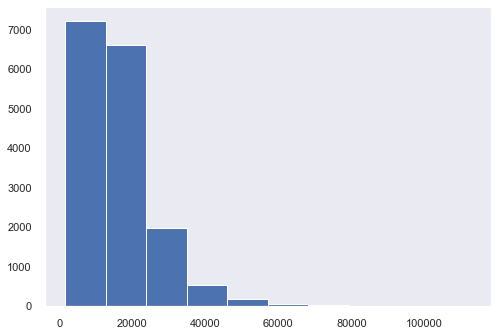

In [95]:
# Creating interaction between grade and size

df_train['grade_x_sqft_living'] = df_train['grade'] * df_train['sqft_living']
df_test['grade_x_sqft_living'] = df_test['grade'] * df_test['sqft_living']

# Check for normality and log new variable if needed
plt.hist(df_train['grade_x_sqft_living'])
plt.show();

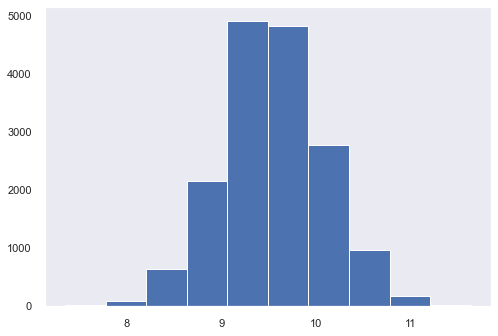

In [96]:
# Log the new interaction variable

df_train['grade_x_sqft_living_log'] = np.log(df_train['grade_x_sqft_living'])
df_test['grade_x_sqft_living_log'] = np.log(df_test['grade_x_sqft_living'])

plt.hist(df_train['grade_x_sqft_living_log'])
plt.show();

Train R2: 0.793
Test R2: 0.799
****
Train RMSE: 173,741
Test RMSE: 179,660
****
Train MAE: 93,268
Test MAE: 95,436

Residual scatter plot:


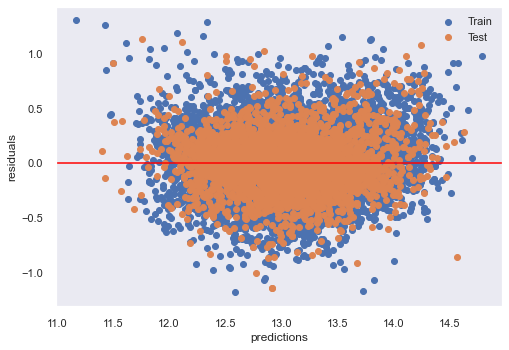



Residual qq plot


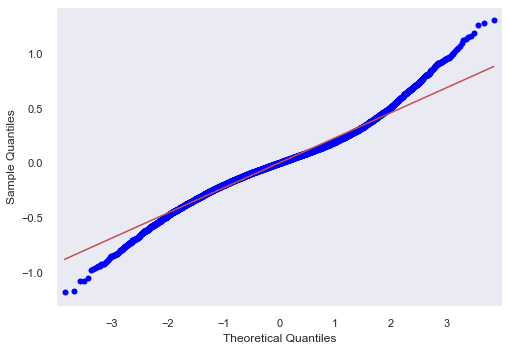

In [97]:
# Test new interaction variable

cols10 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'condition',
        'size_vs_lot_log', 'bath_vs_bed_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated', 'sqft_living_log'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output10, train_preds10, test_preds10 = run_model(df_train, df_test, cols10, True)

evaluate_model(df_train, df_test, cols10, True)

In [98]:
col10_coll_test = df_train[cols10]

high_corr_values = high_corr(col10_coll_test, 0.6)

high_corr_values

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.000000
"(grade_x_sqft_living_log, sqft_living_log)",0.982658


In [99]:
df_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade',
       ...
       'bath_vs_bed', 'bath_vs_bed_log', 'has_yard', 'pre_1970', 'mid_century',
       'recent_build', 'pre_1970_renovated', 'price', 'grade_x_sqft_living',
       'grade_x_sqft_living_log'],
      dtype='object', length=149)

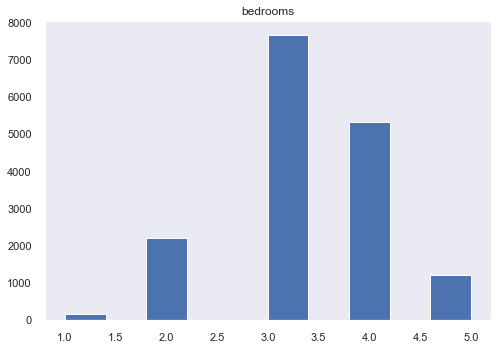

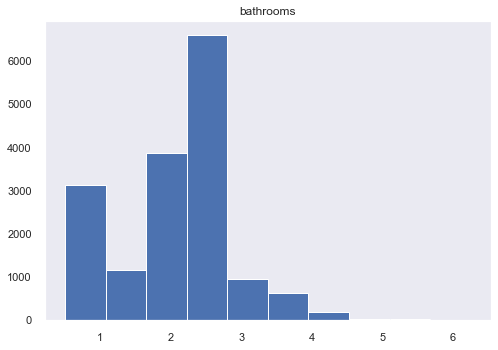

In [100]:
for col in ['bedrooms', 'bathrooms']:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show()
    
# Conclusion: need to log bathrooms to make more normal

Train R2: 0.786
Test R2: 0.791
****
Train RMSE: 177,591
Test RMSE: 184,029
****
Train MAE: 94,971
Test MAE: 97,024

Residual scatter plot:


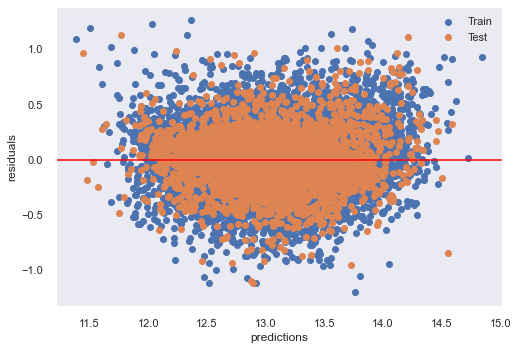



Residual qq plot


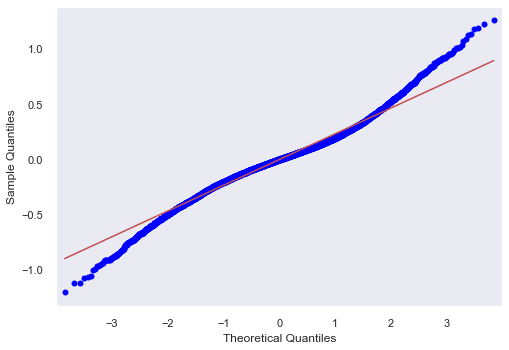

In [101]:
# Remove sqft_living_log

cols11 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'condition',
        'size_vs_lot_log', 'bath_vs_bed_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output11, train_preds11, test_preds11 = run_model(df_train, df_test, cols11, True)

evaluate_model(df_train, df_test, cols11, True)

In [102]:
col11_coll_test = df_train[cols11]

high_corr_values = high_corr(col11_coll_test, 0.6)

high_corr_values

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.0


In [103]:
# Last attempt, trying replacing bathroom and bedroom categoricals with the actual bedroom and bathroom count

df_train['bath_log'] = np.log(df_train['bathrooms'])
df_test['bath_log'] = np.log(df_test['bathrooms'])

In [104]:
df_train['view'].value_counts()

0.0    15053
2.0      703
3.0      332
1.0      249
4.0      217
Name: view, dtype: int64

In [105]:
# Creating a categorical variable for "good view" where the rating is at least 3 out of 4

df_train['good_view'] = 0
df_test['good_view'] = 0

df_train['good_view'].loc[df_train['view'] >= 3] = 1
df_test['good_view'].loc[df_test['view'] >= 3] = 1

In [106]:
df_train.head(1)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98198,zip_98070,zip_98199,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98005,zip_98007,zip_98136,zip_98008,zip_98010,zip_98168,zip_98006,zip_98011,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98155,zip_98032,zip_98033,zip_98034,zip_98031,zip_98038,zip_98166,zip_98040,zip_98042,zip_98045,neighborhood,Renton,Black_Diamond,Lakeland_North,Redmond,Kenmore,Cottage_Lake,Shoreline,Vashon,Sammamish,Kirkland,SeaTac,East_Hill_Meridian,Federal_Way,White_Center,Kent,Auburn,Fall_City,Enumclaw,Bothell,Des_Moines,North_Bend,Seattle,Bryn_Mawr_Skyway,Mercer_Island,Burien,Woodinville,Carnation,Snoqualmie,Bellevue,Tukwila,Maple_Valley,Duvall,Fairwood,Issaquah,Union_Hill_Novelty_Hill,Medina,Covington,sqft_living_log,price_log,living_area_vs_lot,size_vs_lot_log,neighbor_size_vs_lot,sqft_living15_log,bath_vs_bed,bath_vs_bed_log,has_yard,pre_1970,mid_century,recent_build,pre_1970_renovated,price,grade_x_sqft_living,grade_x_sqft_living_log,bath_log,good_view
17729,6/13/2014,4,2.5,2790,43091,2.0,0.0,0.0,4,9,2790,0.0,1989,0.0,98077,47.7759,-122.08,2750,35290,0,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cottage_Lake,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.933797,13.407542,0.032373,-3.43042,0.077926,7.919356,0.625,-0.470004,1,0,1,0,0,665000.0,25110,10.131021,0.916291,0


Train R2: 0.796
Test R2: 0.801
****
Train RMSE: 170,930
Test RMSE: 174,974
****
Train MAE: 93,021
Test MAE: 95,265

Residual scatter plot:


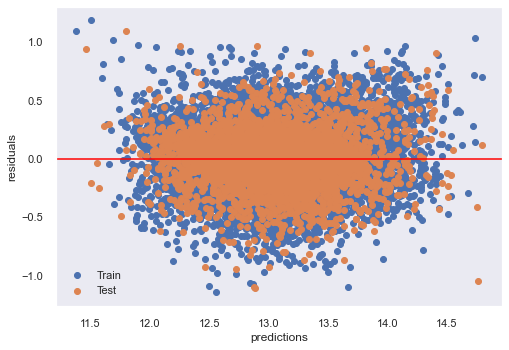



Residual qq plot


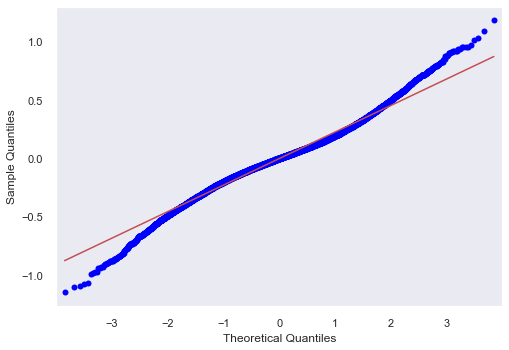

In [107]:
cols12 = ['bath_vs_bed_log', 'bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'condition',
        'size_vs_lot_log', 'has_yard', 'pre_1970', 'recent_build',
        'pre_1970_renovated', 'good_view'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output12, train_preds12, test_preds12 = run_model(df_train, df_test, cols12, True)

evaluate_model(df_train, df_test, cols12, True)

# Evaluation: may use this as final model so we don't have to justify how we decided to cut off bathrooms
# and bedrooms

In [108]:
model_output12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1404.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:13:56   Log-Likelihood:                 857.44
No. Observations:               16554   AIC:                            -1621.
Df Residuals:                   16507   BIC:                            -1258.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.4149      0.056    114.956      0.000       6.305       6.524
bath_vs_bed_log             0.0454      0.008      5.607      0.000       0.030       0.061
bedrooms                   -0.0345      0.004     -9.749      0.000      -0.041      -0.028
multi_story                 0.0218      0.005      4.395      0.000       0.012       0.032
grade_x_sqft_living_log     0.6666      0.006    108.076      0.000       0.655       0.679
basement                   -0.0485      0.005    -10.624      0.000      -0.057      -0.040
condition                   0.0540      0.003     17.815      0.000       0.048       0.060
size_vs_lot_log            -0.0428      0.003    -12.249      0.000      -0.050      -0.036
has_yard                    0.0062      0.007      0.871      0.384      -0.008       0.020
pre_1970                    0.0638      0.006     11.578      0.000       0.053       0.075
recent_build                0.0719      0.008      8.891      0.000       0.056       0.088
pre_1970_renovated          0.0790      0.011      7.149      0.000       0.057       0.101
good_view                   0.3026      0.010     28.914      0.000       0.282       0.323
Renton                     -0.1123      0.017     -6.682      0.000      -0.145      -0.079
Black_Diamond              -0.1770      0.031     -5.789      0.000      -0.237      -0.117
Lakeland_North             -0.4088      0.020    -20.265      0.000      -0.448      -0.369
Redmond                     0.2514      0.018     13.614      0.000       0.215       0.288
Kenmore                     0.0101      0.021      0.473      0.636      -0.032       0.052
Cottage_Lake                0.0544      0.025      2.210      0.027       0.006       0.103
Shoreline                   0.0891      0.018      4.941      0.000       0.054       0.124
Vashon                     -0.0226      0.030     -0.749      0.454      -0.082       0.037
Sammamish                   0.1848      0.018     10.529      0.000       0.150       0.219
Kirkland                    0.2752      0.017     16.068      0.000       0.242       0.309
SeaTac                     -0.3085      0.027    -11.343      0.000      -0.362      -0.255
East_Hill_Meridian         -0.3279      0.022    -15.133      0.000      -0.370      -0.285
Federal_Way                -0.4001      0.018    -22.706      0.000      -0.435      -0.366
White_Center               -0.1044      0.022     -4.800      0.000      -0.147      -0.062
Kent                       -0.3768      0.020    -18.723      0.000      -0.416      -0.337
Auburn                     -0.4001      0.019    -21.354      0.000      -0.437      -0.363
Fall_City                   0.0603      0.036      1.669      0.095      -0.010       0.131
Enumclaw                   -0.3663      0.024  

In [109]:
col12_coll_test = df_train[cols12]

high_corr_values = high_corr(col12_coll_test, 0.6)

high_corr_values

# Comments: final model does not have any independent variables that are too correlated with each other

,cc
pairs,
"(bath_vs_bed_log, bath_vs_bed_log)",1.000000
"(grade_x_sqft_living_log, bedrooms)",0.607157


In [110]:
df_train['grade_x_condition'] = df_train['grade'] * df_train['condition']
df_test['grade_x_condition'] = df_test['grade'] * df_test['condition']

In [111]:
df_train.head(1)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98198,zip_98070,zip_98199,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98005,zip_98007,zip_98136,zip_98008,zip_98010,zip_98168,zip_98006,zip_98011,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98155,zip_98032,zip_98033,zip_98034,zip_98031,zip_98038,zip_98166,zip_98040,zip_98042,zip_98045,neighborhood,Renton,Black_Diamond,Lakeland_North,Redmond,Kenmore,Cottage_Lake,Shoreline,Vashon,Sammamish,Kirkland,SeaTac,East_Hill_Meridian,Federal_Way,White_Center,Kent,Auburn,Fall_City,Enumclaw,Bothell,Des_Moines,North_Bend,Seattle,Bryn_Mawr_Skyway,Mercer_Island,Burien,Woodinville,Carnation,Snoqualmie,Bellevue,Tukwila,Maple_Valley,Duvall,Fairwood,Issaquah,Union_Hill_Novelty_Hill,Medina,Covington,sqft_living_log,price_log,living_area_vs_lot,size_vs_lot_log,neighbor_size_vs_lot,sqft_living15_log,bath_vs_bed,bath_vs_bed_log,has_yard,pre_1970,mid_century,recent_build,pre_1970_renovated,price,grade_x_sqft_living,grade_x_sqft_living_log,bath_log,good_view,grade_x_condition
17729,6/13/2014,4,2.5,2790,43091,2.0,0.0,0.0,4,9,2790,0.0,1989,0.0,98077,47.7759,-122.08,2750,35290,0,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cottage_Lake,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.933797,13.407542,0.032373,-3.43042,0.077926,7.919356,0.625,-0.470004,1,0,1,0,0,665000.0,25110,10.131021,0.916291,0,36


Train R2: 0.800
Test R2: 0.805
****
Train RMSE: 168,428
Test RMSE: 171,876
****
Train MAE: 92,072
Test MAE: 94,086

Residual scatter plot:


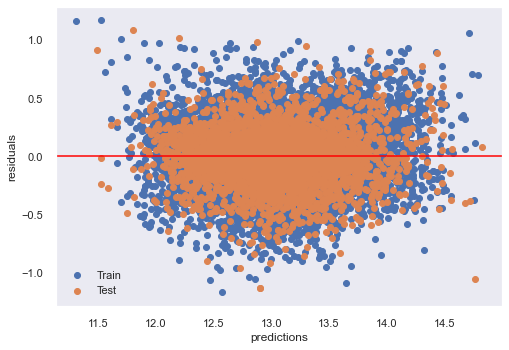



Residual qq plot


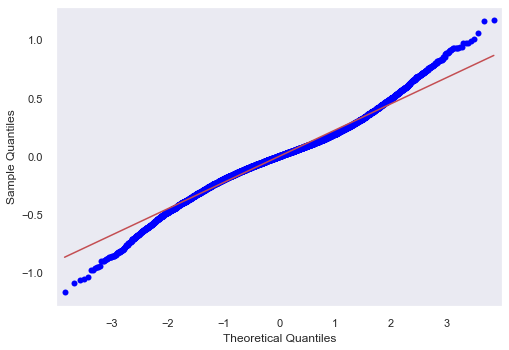

In [138]:
# One final test to determine interaction of grade and condition

cols13 = ['bath_vs_bed', 'bedrooms', 'multi_story', 'grade_x_sqft_living_log', 'basement', 'grade_x_condition',
        'size_vs_lot_log', 'has_yard', 'pre_1970', 'recent_build', 'pre_1970_renovated',
        'good_view'] + [x for x in neighborhood_list if x != 'Snoqualmie']

model_output13, train_preds13, test_preds13 = run_model(df_train, df_test, cols13, True)

evaluate_model(df_train, df_test, cols13, True)

In [139]:
model_output13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1440.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:22:55   Log-Likelihood:                 1021.8
No. Observations:               16554   AIC:                            -1950.
Df Residuals:                   16507   BIC:                            -1587.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.8914      0.053    131.240      0.000       6.788       6.994
bath_vs_bed                 0.0722      0.013      5.685      0.000       0.047       0.097
bedrooms                   -0.0269      0.004     -7.627      0.000      -0.034      -0.020
multi_story                 0.0250      0.005      5.048      0.000       0.015       0.035
grade_x_sqft_living_log     0.6003      0.007     91.621      0.000       0.587       0.613
basement                   -0.0398      0.005     -8.791      0.000      -0.049      -0.031
grade_x_condition           0.0100      0.000     25.684      0.000       0.009       0.011
size_vs_lot_log            -0.0403      0.003    -11.656      0.000      -0.047      -0.034
has_yard                    0.0131      0.007      1.850      0.064      -0.001       0.027
pre_1970                    0.0642      0.005     12.174      0.000       0.054       0.075
recent_build                0.0754      0.008      9.421      0.000       0.060       0.091
pre_1970_renovated          0.0897      0.011      8.209      0.000       0.068       0.111
good_view                   0.2919      0.010     28.135      0.000       0.272       0.312
Renton                     -0.1251      0.017     -7.514      0.000      -0.158      -0.092
Black_Diamond              -0.1843      0.030     -6.089      0.000      -0.244      -0.125
Lakeland_North             -0.4181      0.020    -20.927      0.000      -0.457      -0.379
Redmond                     0.2323      0.018     12.688      0.000       0.196       0.268
Kenmore                    -0.0016      0.021     -0.074      0.941      -0.043       0.040
Cottage_Lake                0.0314      0.024      1.288      0.198      -0.016       0.079
Shoreline                   0.0700      0.018      3.917      0.000       0.035       0.105
Vashon                     -0.0328      0.030     -1.100      0.271      -0.091       0.026
Sammamish                   0.1659      0.017      9.530      0.000       0.132       0.200
Kirkland                    0.2568      0.017     15.125      0.000       0.224       0.290
SeaTac                     -0.3182      0.027    -11.819      0.000      -0.371      -0.265
East_Hill_Meridian         -0.3420      0.021    -15.933      0.000      -0.384      -0.300
Federal_Way                -0.4175      0.017    -23.895      0.000      -0.452      -0.383
White_Center               -0.1191      0.022     -5.531      0.000      -0.161      -0.077
Kent                       -0.3895      0.020    -19.534      0.000      -0.429      -0.350
Auburn                     -0.4127      0.019    -22.230      0.000      -0.449      -0.376
Fall_City                   0.0529      0.036      1.479      0.139      -0.017       0.123
Enumclaw                   -0.3759      0.023  

In [140]:
col13_coll_test = df_train[cols13]

high_corr_values = high_corr(col13_coll_test, 0.6)

high_corr_values

,cc
pairs,
"(bath_vs_bed, bath_vs_bed)",1.0000
"(bedrooms, grade_x_sqft_living_log)",0.6072


### Model normalization

In [115]:
df_sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [141]:
# Use min max scalar with model 12 as a baseline to test normalizaiton

from sklearn.preprocessing import MinMaxScaler

scaler_test = MinMaxScaler()
scaler_train = MinMaxScaler()

scaler_test.fit(df_train[cols13])
scaler_train.fit(df_test[cols13])

df_train_scaled = pd.DataFrame(scaler_test.transform(df_train[cols13]), columns=cols13, index=df_train.index)
df_test_scaled = pd.DataFrame(scaler_test.transform(df_test[cols13]), columns=cols13, index=df_test.index)

df_train_scaled = pd.concat([df_train_scaled, df_train[['price', 'price_log']]], axis=1)
df_test_scaled = pd.concat([df_test_scaled, df_test[['price', 'price_log']]], axis=1)

Train R2: 0.800
Test R2: 0.805
****
Train RMSE: 168,428
Test RMSE: 171,876
****
Train MAE: 92,072
Test MAE: 94,086

Residual scatter plot:


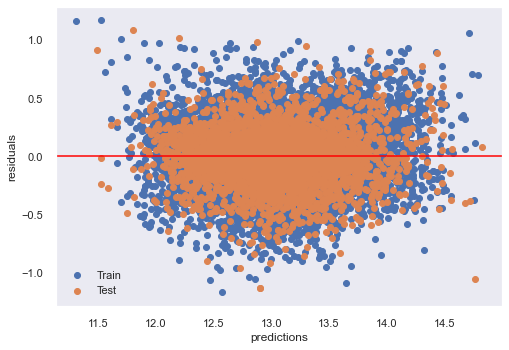



Residual qq plot


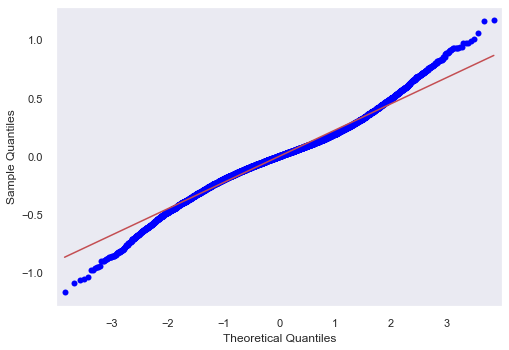

In [142]:
model_output_norm, train_preds_norm, test_preds_norm = run_model(df_train_scaled, df_test_scaled, cols13, True)

evaluate_model(df_train_scaled, df_test_scaled, cols13, True)

In [143]:
pd.options.display.float_format = '{:,.4f}'.format

In [147]:
col_list = ['Intercept'] + cols13

coefficient_dict = {'variables': col_list, 'coefficients': model_output_norm.params.values}

params_df = pd.DataFrame.from_dict(coefficient_dict)
params_df.set_index('variables', inplace=True)

params_df['pvalue'] = model_output_norm.pvalues

In [150]:
params_df['coefficients_abs'] = np.abs(params_df['coefficients'])

In [151]:
params_df['unscaled_coeff']= model_output13.params.values

In [248]:
predictor_graph = params_df.loc[['grade_x_sqft_living_log', 'grade_x_condition', 'size_vs_lot_log', 'bath_vs_bed'], 'coefficients']

In [250]:
predictor_graph_neighborhoods = params_df.loc[['Bellevue', 'Seattle', 'Kirkland', 'Redmond'], 'coefficients']

In [180]:
params_df.sort_values('coefficients', ascending=False)

,coefficients,pvalue,coefficients_abs,unscaled_coeff
variables,,,,
Intercept,11.5533,0.0000,11.5533,6.8914
grade_x_sqft_living_log,2.5695,0.0000,2.5695,0.6003
grade_x_condition,0.5586,0.0000,0.5586,0.0100
Bellevue,0.3475,0.0000,0.3475,0.3475
good_view,0.2919,0.0000,0.2919,0.2919
Seattle,0.2794,0.0000,0.2794,0.2794
Kirkland,0.2568,0.0000,0.2568,0.2568
Redmond,0.2323,0.0000,0.2323,0.2323
Union_Hill_Novelty_Hill,0.1794,0.0000,0.1794,0.1794


In [255]:
params_df.sort_values('coefficients_abs', ascending=False)

# Recommendation 1: Focus on properties with low grade or condition, because improving these results
# in a significantly higher price

# Recommendation 2: Neighborhood recommendation (top 5 from the below).

# Recommendation 3: Square footage is important, but taking up too much of a lot is bad. 
# People value space and yard. So if you increase sq footage, focus on increasing number of stories.

,coefficients,pvalue,coefficients_abs,unscaled_coeff
variables,,,,
Intercept,11.5533,0.0000,11.5533,6.8914
grade_x_sqft_living_log,2.5695,0.0000,2.5695,0.6003
grade_x_condition,0.5586,0.0000,0.5586,0.0100
Lakeland_North,-0.4181,0.0000,0.4181,-0.4181
Federal_Way,-0.4175,0.0000,0.4175,-0.4175
Auburn,-0.4127,0.0000,0.4127,-0.4127
Kent,-0.3895,0.0000,0.3895,-0.3895
Enumclaw,-0.3759,0.0000,0.3759,-0.3759
Covington,-0.3510,0.0000,0.3510,-0.3510


### Zip code regression

In [125]:
data = df_sales.copy()

y2 = data['price']
X2 = data.drop('price', axis=1)

# Split the data out, specifying size of the split
X_train_zip, X_test_zip, y_train_zip, y_test_zip = train_test_split(X2, y2,test_size=0.20,random_state=5)

#Join the dataframes back together 
data_train = pd.concat([X_train_zip, y_train_zip], axis=1)
data_test = pd.concat([X_test_zip, y_test_zip], axis=1)

In [126]:
# Function for zip code categoricals

zipcodes = []
def zipcode_encoder2(df):
    for i in list(set(df['zipcode'])):
        data_train.loc[data_train['zipcode'] == i, 'zip_' + str(i)] = 1
        data_train.loc[data_train['zipcode'] != i, 'zip_' + str(i)] = 0
        
        data_test.loc[data_test['zipcode'] == i, 'zip_' + str(i)] = 1
        data_test.loc[data_test['zipcode'] != i, 'zip_' + str(i)] = 0
        
        zipcodes.append('zip_' + str(i))

In [127]:
zipcode_encoder2(data_train)

In [128]:
df_train['price_log'] = np.log(df_train['price'])
df_test['price_log'] = np.log(df_test['price'])

In [129]:
df_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade',
       ...
       'pre_1970', 'mid_century', 'recent_build', 'pre_1970_renovated',
       'price', 'grade_x_sqft_living', 'grade_x_sqft_living_log', 'bath_log',
       'good_view', 'grade_x_condition'],
      dtype='object', length=152)

Train R2: 0.854
Test R2: 0.856
****
Train RMSE: 141,496
Test RMSE: 153,180
****
Train MAE: 77,126
Test MAE: 79,687

Residual scatter plot:


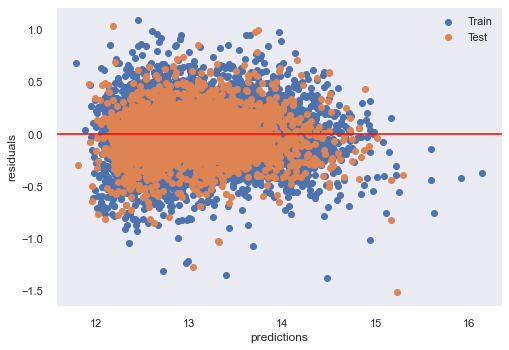



Residual qq plot


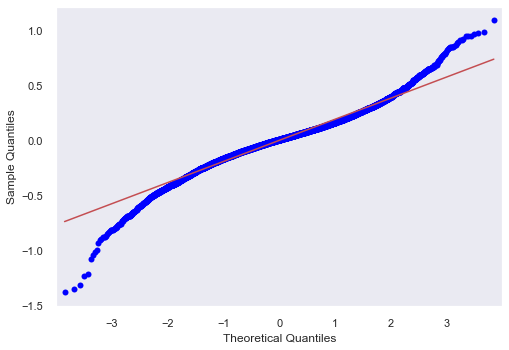

In [133]:
model_columns = zipcode_column_builder(df_train, ['sqft_living', 'grade', 'view'])
zip_output, zip_train_preds, zip_test_preds = run_model(df_train, df_test, model_columns, True)

evaluate_model(df_train, df_test, model_columns, True)

### 'Final' Model

- Zipcodes was slightly more predictive than our simple model, but ultimately, we opted for less accuracy to help with business understanding
- As our final model, we chose the model that combines several key features of the house along with neighborhood
- This produces an R2 of 0.8, with reasonable reproducability in our Test dataset
- The MAE is 92K, meaning on average, we're off by that amount from the actual sale price on average
- The model does a decent job of adhering to the rules of linear regression. There is no discernable trend in the scatter plot of the residuals. The QQ plot has issues at the extremes, but generally follows the 45 degree line.
- There is not significant multicollinearity among the independent variables. The most highly correlated is the interaction of sqft living area and grade vs. bedrooms at 0.6. This is generally below the rough threshold of 0.75 where you might expect to have signficant issues here.
- We believe we've taken all reasonable steps to address the linear regression rules, including log transforming variables without a normal distribution, dropping variables with high collinearity, and log transforming our dependent variable.

Train R2: 0.800
Test R2: 0.805
****
Train RMSE: 168,428
Test RMSE: 171,876
****
Train MAE: 92,072
Test MAE: 94,086

Residual scatter plot:


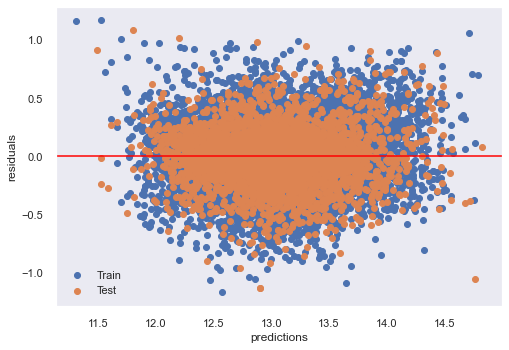



Residual qq plot


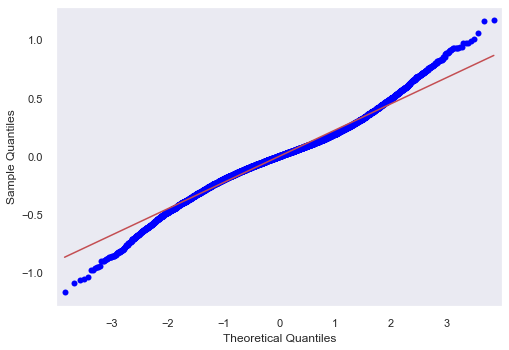

In [217]:
final_cols = cols13

final_output, final_train_preds, final_test_preds = run_model(df_train, df_test, final_cols, True)

evaluate_model(df_train, df_test, final_cols, True)

In [218]:
final_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1440.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:04:17   Log-Likelihood:                 1021.8
No. Observations:               16554   AIC:                            -1950.
Df Residuals:                   16507   BIC:                            -1587.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.8914      0.053    131.240      0.000       6.788       6.994
bath_vs_bed                 0.0722      0.013      5.685      0.000       0.047       0.097
bedrooms                   -0.0269      0.004     -7.627      0.000      -0.034      -0.020
multi_story                 0.0250      0.005      5.048      0.000       0.015       0.035
grade_x_sqft_living_log     0.6003      0.007     91.621      0.000       0.587       0.613
basement                   -0.0398      0.005     -8.791      0.000      -0.049      -0.031
grade_x_condition           0.0100      0.000     25.684      0.000       0.009       0.011
size_vs_lot_log            -0.0403      0.003    -11.656      0.000      -0.047      -0.034
has_yard                    0.0131      0.007      1.850      0.064      -0.001       0.027
pre_1970                    0.0642      0.005     12.174      0.000       0.054       0.075
recent_build                0.0754      0.008      9.421      0.000       0.060       0.091
pre_1970_renovated          0.0897      0.011      8.209      0.000       0.068       0.111
good_view                   0.2919      0.010     28.135      0.000       0.272       0.312
Renton                     -0.1251      0.017     -7.514      0.000      -0.158      -0.092
Black_Diamond              -0.1843      0.030     -6.089      0.000      -0.244      -0.125
Lakeland_North             -0.4181      0.020    -20.927      0.000      -0.457      -0.379
Redmond                     0.2323      0.018     12.688      0.000       0.196       0.268
Kenmore                    -0.0016      0.021     -0.074      0.941      -0.043       0.040
Cottage_Lake                0.0314      0.024      1.288      0.198      -0.016       0.079
Shoreline                   0.0700      0.018      3.917      0.000       0.035       0.105
Vashon                     -0.0328      0.030     -1.100      0.271      -0.091       0.026
Sammamish                   0.1659      0.017      9.530      0.000       0.132       0.200
Kirkland                    0.2568      0.017     15.125      0.000       0.224       0.290
SeaTac                     -0.3182      0.027    -11.819      0.000      -0.371      -0.265
East_Hill_Meridian         -0.3420      0.021    -15.933      0.000      -0.384      -0.300
Federal_Way                -0.4175      0.017    -23.895      0.000      -0.452      -0.383
White_Center               -0.1191      0.022     -5.531      0.000      -0.161      -0.077
Kent                       -0.3895      0.020    -19.534      0.000      -0.429      -0.350
Auburn                     -0.4127      0.019    -22.230      0.000      -0.449      -0.376
Fall_City                   0.0529      0.036      1.479      0.139      -0.017       0.123
Enumclaw                   -0.3759      0.023  

In [219]:
final_corr_matrix = high_corr(df_train[final_cols], 0.6)

final_corr_matrix

,cc
pairs,
"(bath_vs_bed, bath_vs_bed)",1.0000
"(bedrooms, grade_x_sqft_living_log)",0.6072


In [220]:
final_cols

['bath_vs_bed',
 'bedrooms',
 'multi_story',
 'grade_x_sqft_living_log',
 'basement',
 'grade_x_condition',
 'size_vs_lot_log',
 'has_yard',
 'pre_1970',
 'recent_build',
 'pre_1970_renovated',
 'good_view',
 'Renton',
 'Black_Diamond',
 'Lakeland_North',
 'Redmond',
 'Kenmore',
 'Cottage_Lake',
 'Shoreline',
 'Vashon',
 'Sammamish',
 'Kirkland',
 'SeaTac',
 'East_Hill_Meridian',
 'Federal_Way',
 'White_Center',
 'Kent',
 'Auburn',
 'Fall_City',
 'Enumclaw',
 'Bothell',
 'Des_Moines',
 'North_Bend',
 'Seattle',
 'Bryn_Mawr_Skyway',
 'Burien',
 'Woodinville',
 'Carnation',
 'Bellevue',
 'Tukwila',
 'Maple_Valley',
 'Duvall',
 'Fairwood',
 'Issaquah',
 'Union_Hill_Novelty_Hill',
 'Covington']

## Model visualizations

<ipython-input-249-2a23384bbf2e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=12, color='black')


variables
grade_x_sqft_living_log    2.5695
grade_x_condition          0.5586
size_vs_lot_log           -0.2671
bath_vs_bed                0.1671
Name: coefficients, dtype: float64

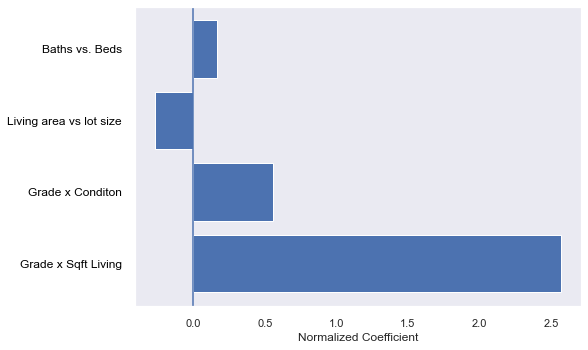

In [249]:
fig, ax = plt.subplots()

y = ['Grade x Sqft Living', 'Grade x Conditon', 'Living area vs lot size', 'Baths vs. Beds']

ax.barh(y = y, width = predictor_graph);
ax.set_yticklabels(y, fontsize=12, color='black')
ax.axvline(x=0, ymin=0, ymax=1)
ax.set_xlabel('Normalized Coefficient', fontsize=12)

plt.yticks(rotation = 0, wrap=True)
predictor_graph

In [ ]:
predictor_graph_neighborhoods = params_df.loc[['Bellevue', 'Seattle', 'Kirkland', 'Redmond'], 'coefficients']

<ipython-input-251-9cf1025b3fd5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=12, color='black')


variables
grade_x_sqft_living_log    2.5695
grade_x_condition          0.5586
size_vs_lot_log           -0.2671
bath_vs_bed                0.1671
Name: coefficients, dtype: float64

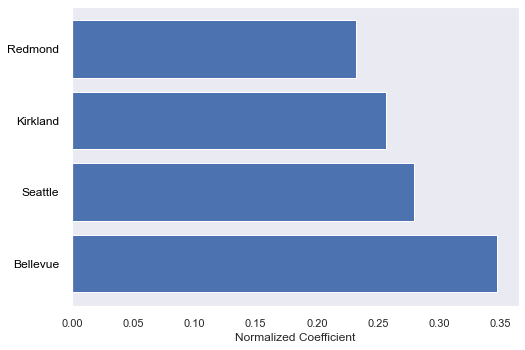

In [251]:
fig, ax = plt.subplots()

y = ['Bellevue', 'Seattle', 'Kirkland', 'Redmond']

ax.barh(y = y, width = predictor_graph_neighborhoods);
ax.set_yticklabels(y, fontsize=12, color='black')
ax.axvline(x=0, ymin=0, ymax=1)
ax.set_xlabel('Normalized Coefficient', fontsize=12)

plt.yticks(rotation = 0, wrap=True)
predictor_graph

In [182]:
df_test.head(1)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98198,zip_98070,zip_98199,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98005,zip_98007,zip_98136,zip_98008,zip_98010,zip_98168,zip_98006,zip_98011,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98155,zip_98032,zip_98033,zip_98034,zip_98031,zip_98038,zip_98166,zip_98040,zip_98042,zip_98045,neighborhood,Renton,Black_Diamond,Lakeland_North,Redmond,Kenmore,Cottage_Lake,Shoreline,Vashon,Sammamish,Kirkland,SeaTac,East_Hill_Meridian,Federal_Way,White_Center,Kent,Auburn,Fall_City,Enumclaw,Bothell,Des_Moines,North_Bend,Seattle,Bryn_Mawr_Skyway,Mercer_Island,Burien,Woodinville,Carnation,Snoqualmie,Bellevue,Tukwila,Maple_Valley,Duvall,Fairwood,Issaquah,Union_Hill_Novelty_Hill,Medina,Covington,sqft_living_log,price_log,living_area_vs_lot,size_vs_lot_log,neighbor_size_vs_lot,sqft_living15_log,bath_vs_bed,bath_vs_bed_log,has_yard,pre_1970,mid_century,recent_build,pre_1970_renovated,price,grade_x_sqft_living,grade_x_sqft_living_log,bath_log,good_view,grade_x_condition
4431,11/17/2014,3,1.5000,1090,7698,1.0000,0.0000,0.0000,5,7,1090,0.0000,1966,0.0000,98058,47.4553,-122.1740,1540,7624,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Fairwood,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,6.9939,12.4290,0.1416,-1.9548,0.2020,7.3395,0.5000,-0.6931,1,1,0,0,0,"249,950.0000",7630,8.9398,0.4055,0,35


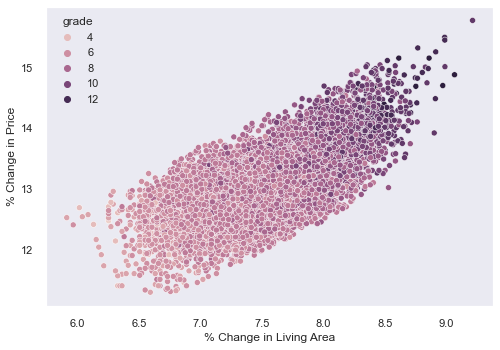

In [203]:
# Regplot of sq footage, log price, with grade as hue
fig, ax = plt.subplots()

sns.scatterplot(x='sqft_living_log', y='price_log', data=df_train, hue='grade', ax=ax);
ax.set_xlabel('% Change in Living Area', fontsize=12)
ax.set_ylabel('% Change in Price', fontsize=12);

In [273]:
top_neighborhoods = ['Bellevue', 'Seattle', 'Kirkland', 'Redmond']

neighborhood_list = []
for i in df_train['neighborhood']:
    if i in top_neighborhoods:
        neighborhood_list.append(1)
    else:
        neighborhood_list.append(0)
        
df_neighborhood = df_train.copy()

df_neighborhood['top_neighborhood'] = neighborhood_list

# Repeat above only for most impactful neighborhoods

df_neighborhood = df_neighborhood[df_neighborhood['top_neighborhood'] == 1]

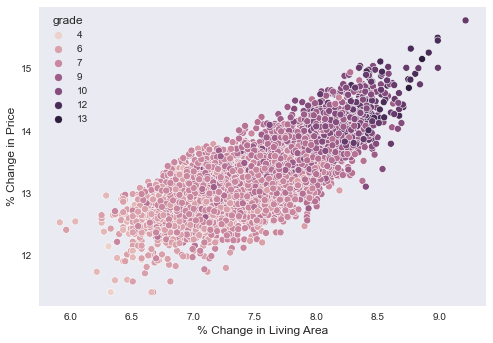

In [275]:
# Regplot of sq footage, log price, with grade as hue
fig, ax = plt.subplots()

sns.scatterplot(x='sqft_living_log', y='price_log', data=df_neighborhood, hue='grade', ax=ax);
ax.set_xlabel('% Change in Living Area', fontsize=12)
ax.set_ylabel('% Change in Price', fontsize=12)
ax.grid(False);

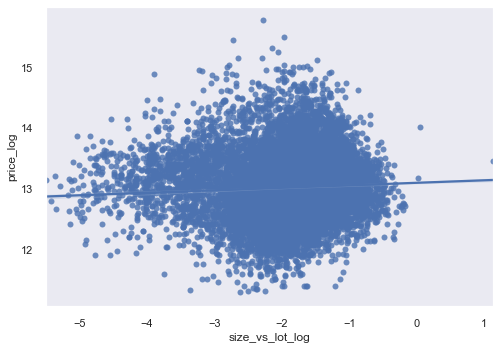

In [254]:
# Regplot of sq footage, log price, with grade as hue
fig, ax = plt.subplots()

sns.regplot(x='size_vs_lot_log', y='price_log', data=df_train);
# ax.set_xlabel('% Change in Living Area', fontsize=12)
# ax.set_ylabel('% Change in Price', fontsize=12);

In [214]:
medina_avg = 2056771
mercer_avg = 1174230
overall_avg = 533697

medina_change = (medina_avg - overall_avg) / overall_avg
mercer_change = (mercer_avg - overall_avg) / overall_avg

print(medina_change, mercer_change)

2.8538178029855894 1.200181001579548


In [215]:
# sales_clean.groupby('neighborhood')['price'].mean().sort_values(ascending=False)

In [227]:
bedroom_2 = df_train[df_train['bedrooms'] == 2]

In [230]:
bedroom_2_bath_1 = bedroom_2[bedroom_2['bathrooms'] == 1]
bedroom_2_bath_2 = bedroom_2[bedroom_2['bathrooms'] == 2]

In [235]:
mean1 = bedroom_2_bath_1['price'].mean()

In [236]:
mean2 = bedroom_2_bath_2['price'].mean()

In [237]:
(mean2 - mean1) / mean1

0.2939961097708744

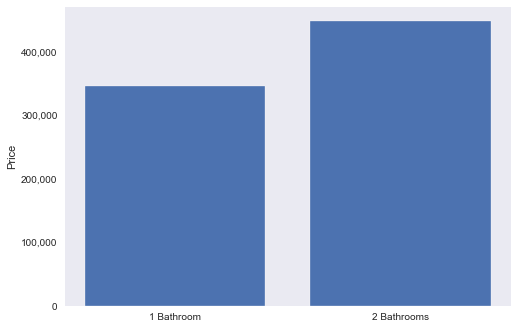

In [270]:
fig, ax = plt.subplots()

height = [bedroom_2_bath_1['price'].mean(), bedroom_2_bath_2['price'].mean()]

x = ['1 Bathroom', '2 Bathrooms']

ax.bar(x=x, height=height)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Price')
ax.grid(False);

In [276]:
big_yard = df_train[df_train['living_area_vs_lot'] < 0.5]
small_yard = df_train[df_train['living_area_vs_lot'] >= 0.5]

In [277]:
(big_yard['price'].mean() - small_yard['price'].mean()) / small_yard['price'].mean()

0.13563081189333126

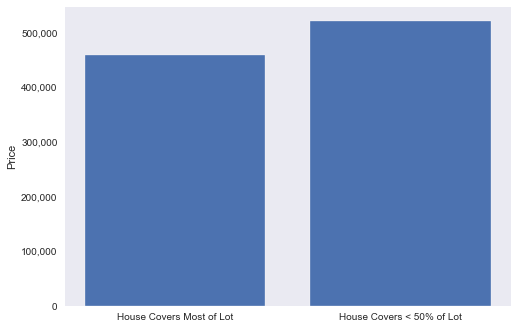

In [280]:
fig, ax = plt.subplots()

height = [small_yard['price'].mean(), big_yard['price'].mean()]

x = ['House Covers Most of Lot', 'House Covers < 50% of Lot']

ax.bar(x=x, height=height)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Price')
ax.grid(False);

## Conclusions

Ultimately, we were able to produce a reasonably predictive model while keep several features that could help inform actionable business recommendations.

These recommendations are:
- Focus on buying low quality, small homes in [insert list of neighborhoods here] as grade and size are very important drivers of increased price
- But don't build too big! Sq ft of the living area vs. lot size has a very negative relationship with price. People like their lawns. If you're going to increase the square footage of the house, build up, not out.

Next steps:
- There is nothing in this dataset with regards to profitability. While we suggest improving the grade (quality) of the house is a meaningful way to increase price, we can't say how expensive those changes are to implement. The next step would be to incorporate expenses into the model so that the outcome could be some expense-adjusted measure of price.
- There is no time element to the dataset. It only includes home sales from September to January for a single year. There is not enough data to concluce whether waiting to sell in a particular season or time of year is beneficial. We'd like to expand the dataset to do a temporal analysis across multiple years


In [ ]:
# Code for visualization location vs. price

# Import
# import plotly.express as px

# # Explore relationship between location and price
# fig = px.scatter_mapbox(data_frame = train_df, # df name
#                         lat='lat', # name of latitude column
#                         lon='long', # name of longitude column
#                         color='price', # name of column to use for the color
#                         zoom=8)
# fig.update_layout(mapbox_style="open-street-map")
# fig.show()